In [4265]:
import numpy as np
import pandas as pd

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Colors are at https://developer.mozilla.org/en-US/docs/Web/CSS/color_value

## 2021 Kaggle Machine Learning & Data Science Survey

### Prologue

I am a **45+ years woman** in technology space for over 2 decades and in data science space for barely 3 years! I am curious...curious to know how the **Womaen >40years** practitioners are faring in the ML and DS field! 

#### TODO
- TODO: Remove extra prints
- TODO: Verify data
- TODO: Number the headings
- Put appropriate labels in the bar plots

##### Dataset:  
Industry-wide survey of the state of data science and machine learning with **25,973** responses!

##### Objective:
**Tell a data story** about a subset of the data science community represented in this survey, through a combination of both **narrative text** and **data exploration**. A “story” could be defined any number of ways, and that’s deliberate. The challenge is to deeply explore (through data) the impact, priorities, or concerns of a specific group of data science and machine learning practitioners. That group can be defined in the macro (for example: anyone who does most of their coding in Python) or the micro (for example: female data science students studying machine learning in masters programs). This is an opportunity to be creative and tell the story of a community you identify with or are passionate about!
- **Composition** - Is there a clear narrative thread to the story that’s articulated and supported by data? The subject should be well defined, well researched, and well supported through the use of data and visualizations.
- **Originality** - Does the reader learn something new through this submission? Or is the reader challenged to think about something in a new way? A great entry will be informative, thought provoking, and fresh all at the same time.
- **Documentation** - Are your code, and notebook, and additional data sources well documented so a reader can understand what you did? Are your sources clearly cited? A high quality analysis should be concise and clear at each step so the rationale is easy to follow and the process is reproducible

#### Functions

In [4266]:
df_RESULT = pd.DataFrame()

In [4267]:
def percent(val, total):
    return round(100 * val/total, 2)

In [4268]:
def printCols(cat, cols, cols_top3, cols_other, cols_none):
    print(f"COLS_{cat}       {len(cols):2d}", end=': ');          [print(col[0], end=', ') for col in cols]; print()
    print(f"COLS_{cat}_TOP3  {len(cols_top3):2d}", end=': ');     [print(col, end=', ') for col in cols_top3]; print()
    print(f"COLS_{cat}_OTHER {len(cols_other):2d}", end=': ');    [print(col[0], end=', ') for col in cols_other]; print()
    print(f"COLS_{cat}_NONE  {len(cols_none):2d}", end=': ');     [print(col[0], end=', ') for col in cols_none]; print()

def getCols(cat, colprefix,colnone):
    PREFIX_LEN = len(colprefix)
    COLS_NONE = list(filter(lambda x: True if x[0]==colnone else False, df.columns.to_list()))
    COLS = list(filter(lambda x: True if x[0][:PREFIX_LEN]==colprefix and x not in COLS_NONE else False, df.columns.to_list()))
    COLS_TOP3    = [x[0] for x in df[COLS].count().sort_values(ascending=False).index[:3].values]
    COLS_OTHER   = list(filter(lambda x: True if x[0] not in COLS_TOP3 else False, COLS))
    printCols(cat, COLS, COLS_TOP3, COLS_OTHER, COLS_NONE)
    return COLS, COLS_TOP3, COLS_OTHER, COLS_NONE
    
def convert2percent(df, col, total_col):
    df[col] = df[col]/ df[total_col]
    return df[col].apply(lambda x: round(x*100,2))

# Inplace of column with string values, create a new column with 1s & 0s 
# Old: df[('Q7_Part_1', 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python')] = 'Python'
# New: df['Python'] = 1
def createNewCol(df_old, oldCol, df_new, newCol, value):
    df_new[newCol] = df_old[oldCol]
    # strip the value of the leading and trailing empty spaces
    df_new.loc[~df_new[newCol].isnull(), newCol] = df_new[~df_new[newCol].isnull()][newCol].apply(lambda x: x.strip())
    return  df_new[newCol].apply(lambda x: 1 if x== value else 0)

# Create a dataframe with overall and specific category values. Plot a bar graph to compare 
def compare(df, df_overall, df_specific, cat_other, col_other, ax, title=''):
    # Create a df with the overall users as percentage
    df_all = pd.DataFrame()
    df_all.loc['Count','Overall']=df.shape[0]
    df_all = pd.concat([df_all, df_specific])
    df_all.loc[cat_other,'Overall']=df_all.loc[cat_other,'Overall']/len(col_other)
    df_all['Overall'] = df_all['Overall'].apply(lambda x: round((x/df.shape[0])*100,2))
    #df_pl_all

    # Create different df for woman < 40 and woman > 40
    df_woman_lt40 = df_overall.loc[('<40', 'Woman'),:].to_frame()#; print("df_pl_woman_lt40\n", df_pl_woman_lt40);print()
    df_woman_gt40 = df_overall.loc[('>40', 'Woman'),:].to_frame()#; print("df_pl_woman_gt40\n", df_pl_woman_gt40)

    # Concatenate the overall and the woman < 40 and woman > 40 data 
    df_temp = pd.concat([df_all, df_woman_lt40, df_woman_gt40], axis=1, join='inner') 
    #print(df_temp)
    df_temp.drop('Count', inplace=True)
    ax = df_temp.plot.bar( ylim=(0,100), ax=ax);annotate(ax, title) #figsize=(15, 6),
    return df_temp

# Create a dataframe with users wrt Age-group and Gender 
def createSpecificAndSummary(df,topcol1, topcol2, topcol3, othercol, nonecol, othercols):
    df_temp = df.agg({topcol1:np.sum,topcol2:np.sum,topcol3:np.sum, othercol:np.sum, nonecol:np.sum}).to_frame()
    df_temp.rename(columns={0:"Overall"}, inplace=True)
    #print(df_temp)

    df_summary = df.groupby(by=['AgeGroup','Gender']).agg({'AgeGroup':'count',topcol1:np.sum,topcol2:np.sum,topcol3:np.sum, othercol:np.sum, nonecol:np.sum})
    df_summary.rename(columns={"AgeGroup":"Count"}, inplace=True)

    df_summary[topcol1] = convert2percent(df_summary,topcol1,"Count")
    df_summary[topcol2] = convert2percent(df_summary,topcol2,"Count")
    df_summary[topcol3] = convert2percent(df_summary,topcol3,"Count")

    df_summary[othercol]  = df_summary[othercol]/ df_summary["Count"]
    df_summary[othercol]  = df_summary[othercol].apply(lambda x: round(x*100/len(othercols),2))

    df_summary[nonecol]   = convert2percent(df_summary,nonecol,"Count")
    df_summary['Count']   = df_summary['Count'].apply(lambda x: round((x/df.shape[0])*100,2))
    return df_temp, df_summary

# Summarise the values of the category - total, top 3 values, other & none
def summarise(df, df_new, cat, cols, cols_other, col_none, 
                        top1col1, top1col2, top1val, 
                        top2col1, top2col2, top2val, 
                        top3col1, top3col2, top3val, ax=None, title=""):

    COL_COUNT = f'{cat}-Count'
    COL_OTHER = f'{cat}-Other'
    COL_NONE  = f'{cat}-None'

    df_new[COL_COUNT]  = df[cols].count(axis=1)
    df_new[top1col2]   = createNewCol(df, top1col1 , df_new, top1col2, top1val)
    df_new[top2col2]   = createNewCol(df, top2col1 , df_new, top2col2, top2val)
    df_new[top3col2]   = createNewCol(df, top3col1 , df_new, top3col2, top3val)

    df_new[COL_NONE]   = createNewCol(df, col_none, df_new, COL_NONE, "None")

    df_new[COL_OTHER]  = df[cols_other].count(axis=1) 
    df_new[COL_COUNT]  = df[cols].count(axis=1) # None is not considered

    # Fill None for rows where no option was selected
    #print("BEFORE", df_new[(df_new[COL_COUNT]==0)][COL_COUNT].sum(), df_new[COL_NONE].sum())
    df_new.loc[(df_new[COL_COUNT]==0) & (df_new[COL_NONE]==0), COL_NONE] = 1
    #print("AFTER", df_new[COL_NONE].sum())

    #print(df_new.head())
    # Update the median and max values in the df_RESULT
    df_RESULT.loc[cat,'Count-Median'] = df_new[COL_COUNT].median()
    df_RESULT.loc[cat,'W<40-Median'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='<40')][COL_COUNT].median()
    df_RESULT.loc[cat,'W>40-Median'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='>40')][COL_COUNT].median()

    df_RESULT.loc[cat,'Count-Max'] = df_new[COL_COUNT].max()
    df_RESULT.loc[cat,'W<40-Max'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='<40')][COL_COUNT].max()
    df_RESULT.loc[cat,'W>40-Max'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='>40')][COL_COUNT].max()

    # Create a df with the IDE and total number of IDE users
    df_temp, df_summary = createSpecificAndSummary(df_new, top1col2, top2col2, top3col2, COL_OTHER, COL_NONE, cols_other)

    df_ = compare(df, df_summary, df_temp, COL_OTHER, cols_other, ax, title)
    #plotBox(df_new, COL_COUNT)  
    return df_    

##### Visulisations

In [4269]:
def plotBox(df, col):
    df_man = df[df['Gender']=='Man'][['AgeGroup', col]]#;print(df_man.head())
    df_woman = df[df['Gender']=='Woman'][['AgeGroup', col]]#;print(df_woman.head())
    plt.figure(figsize=(18, 5), dpi=80)

    ax = plt.subplot(1, 4, 1); df_woman[df_woman['AgeGroup']=='<40'].hist(ax=ax); plt.title('Woman < 40')
    ax = plt.subplot(1, 4, 2); df_woman[df_woman['AgeGroup']=='>40'].hist(ax=ax); plt.title('Woman > 40') 
    ax = plt.subplot(1, 4, 3); df_man.boxplot(by='AgeGroup', ax=ax); ax.set_title('Man')        
    ax = plt.subplot(1, 4, 4); df_woman.boxplot(by='AgeGroup',ax=ax); ax.set_title('Woman') 

def plotSankey(nodes, links, title, width, height):
    data = go.Sankey(node = nodes, link = links)
    fig = go.Figure(data)
    fig.update_layout(title=title,  font_size=16, width=width,height=height,)
    fig.show()

def showTreeMap(df, tree, values, title):
    fig = px.treemap(df, path=[px.Constant("all")] + tree, values=values,     
                    color_discrete_map={'(?)':'lightgrey', 'Lunch':'gold', 'Dinner':'darkblue'})
    fig.update_traces(root_color="lightgrey")
    #fig.update_traces(hovertemplate=)
    fig.update_layout(title=title,  margin = dict(t=50, l=25, r=25, b=25))
    fig.show()

def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

#### Read dataset

In [4270]:
df = pd.read_csv('data/kaggle_survey_2021_responses.csv', header=[0,1])

/Users/sreedevigattu/sree/projects/mlds/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (195,201) have mixed types.Specify dtype option on import or set low_memory=False.



In [4271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25973 entries, 0 to 25972
Columns: 369 entries, ('Time from Start to Finish (seconds)', 'Duration (in seconds)') to ('Q38_B_OTHER', 'In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Other')
dtypes: float64(8), int64(1), object(360)
memory usage: 73.1+ MB


In [4272]:
print(df.columns.tolist()[0:10])

[('Time from Start to Finish (seconds)', 'Duration (in seconds)'), ('Q1', 'What is your age (# years)?'), ('Q2', 'What is your gender? - Selected Choice'), ('Q3', 'In which country do you currently reside?'), ('Q4', 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'), ('Q5', 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'), ('Q6', 'For how many years have you been writing code and/or programming?'), ('Q7_Part_1', 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python'), ('Q7_Part_2', 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R'), ('Q7_Part_3', 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL')]


In [4273]:
df.iloc[0,:].to_frame().to_csv("Columns.csv")

<AxesSubplot:>

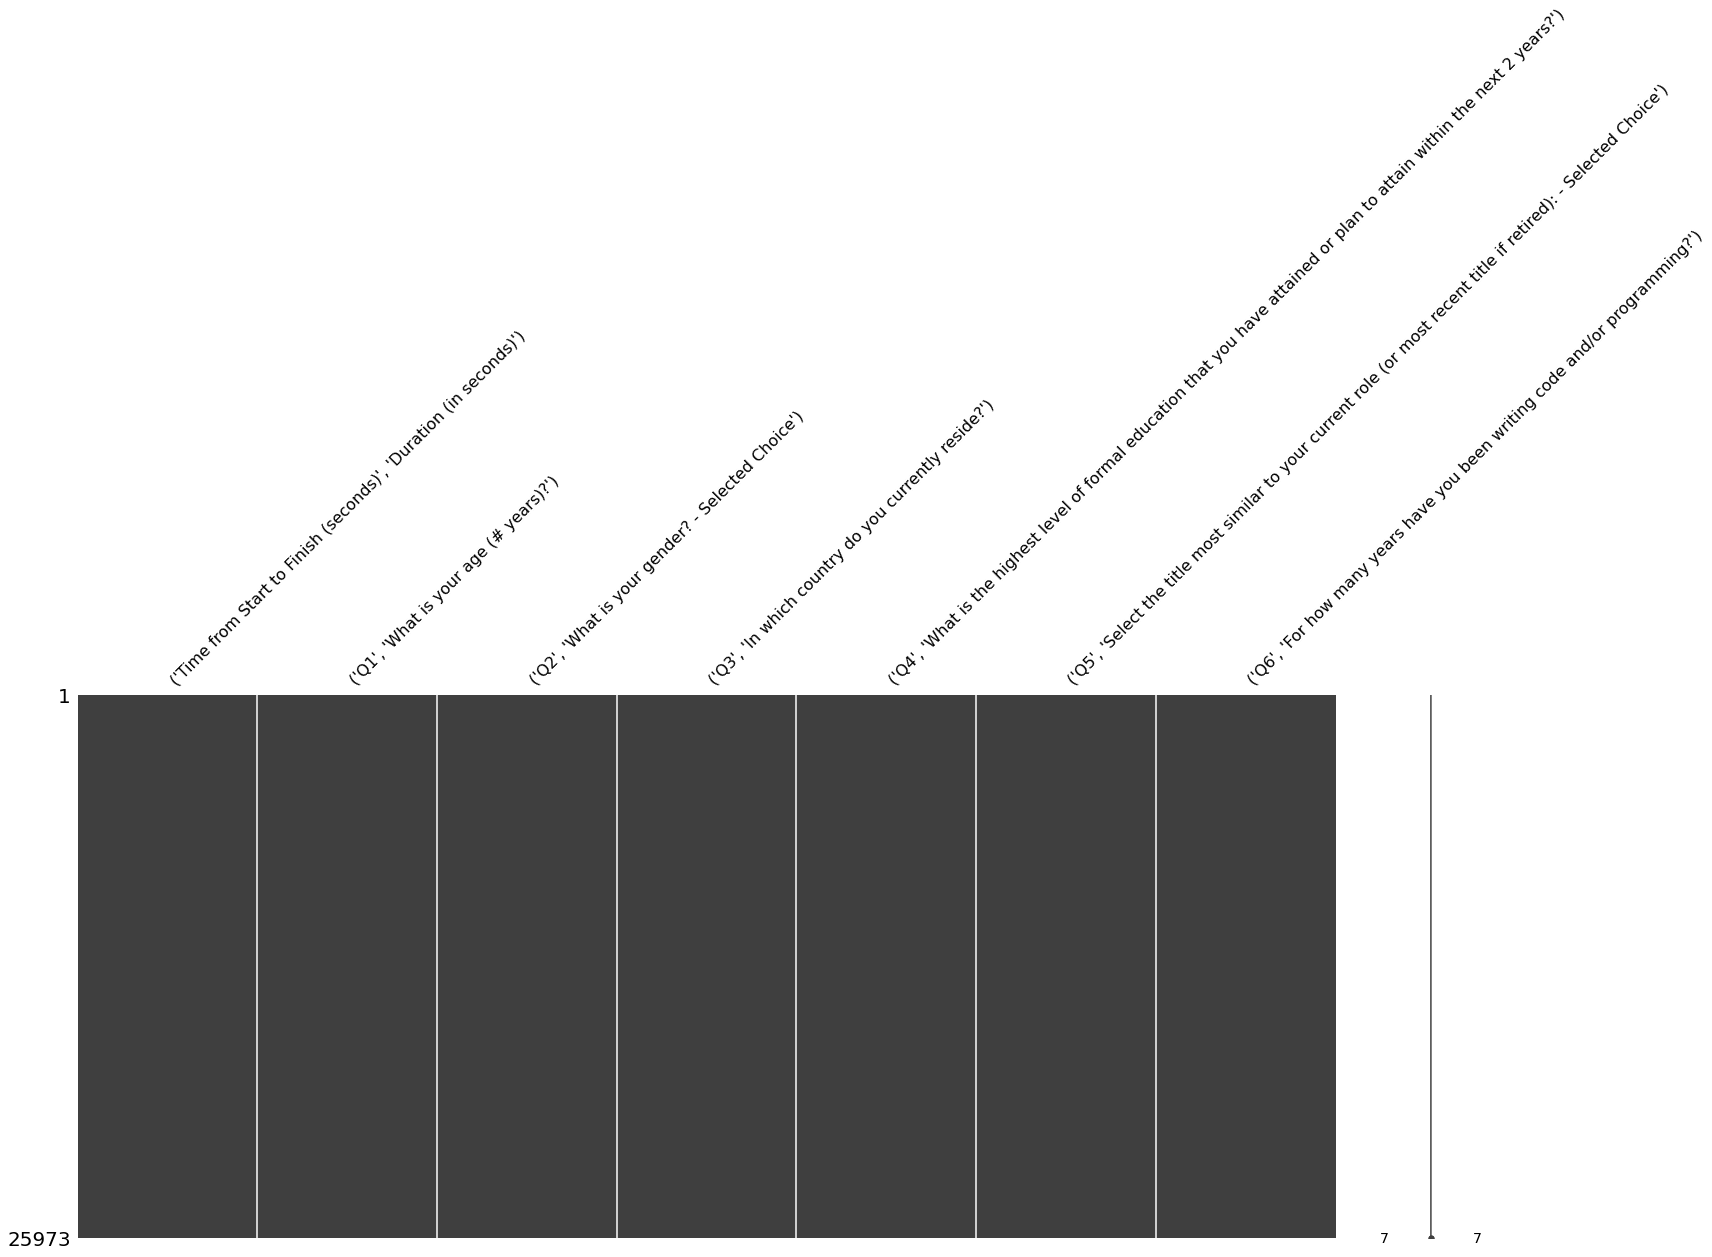

In [4274]:
msno.matrix(df.iloc[:,:7])

#### Age and Gender - Data processing

In [4275]:
df_new = pd.DataFrame()
df_new['Age']       = df['Q1', 'What is your age (# years)?']
df_new['Gender']    = df['Q2', 'What is your gender? - Selected Choice']
df_new['Country']   = df['Q3', 'In which country do you currently reside?']
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25973 entries, 0 to 25972
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Age      25973 non-null  object
 1   Gender   25973 non-null  object
 2   Country  25973 non-null  object
dtypes: object(3)
memory usage: 608.9+ KB


In [4276]:
df_new.groupby(by='Age').agg({"Age":'count'}).rename(columns={'Age':'Count'}).reset_index(inplace=True)
print(df_new['Gender'].value_counts())
print(df_new.head())

Man                        20598
Woman                       4890
Prefer not to say            355
Nonbinary                     88
Prefer to self-describe       42
Name: Gender, dtype: int64
     Age Gender    Country
0  50-54    Man      India
1  50-54    Man  Indonesia
2  22-24    Man   Pakistan
3  45-49    Man     Mexico
4  45-49    Man      India


In [4277]:
df_new['Gender'] = df_new['Gender'].apply(lambda x: x if x in ['Man', 'Woman'] else 'Other')
df_new["AgeGroup"] = df_new['Age'].apply(lambda x: '<40' if x in ['18-21', '22-24', '25-29', '30-34', '35-39'] else '>40')
df_new.head()

,Age,Gender,Country,AgeGroup
0,50-54,Man,India,>40
1,50-54,Man,Indonesia,>40
2,22-24,Man,Pakistan,<40
3,45-49,Man,Mexico,>40
4,45-49,Man,India,>40


In [4278]:
COLS_GENDER = ['Man', 'Woman', 'Other']
COLS_AGE = ['18-29','30-39','40-49','50-59','60-69','70+']
COLOR_MAP_GENDER = {'(?)':'lightgrey', 'Man':'dodgerblue', 'Woman':'lightcoral', 'Other':'gold'}

def getAgeGenderPivotDF():
    COLS_18_29, COLS_30_39, COLS_40_49, COLS_50_59 = ['18-21', '22-24', '25-29'], ['30-34','35-39'], ['40-44','45-49'], ['50-54','55-59']

    df_ = df_new.groupby(by=['Age','Gender']).agg({'Gender':'count'}).rename(columns={'Gender':'Count'})
    df_.reset_index(inplace=True)
    #print(df_.head())

    df_summary = pd.pivot_table(data = df_,  values='Count', index=['Age'], columns=['Gender'], aggfunc=np.sum, fill_value=0)
    df_summary = df_summary[COLS_GENDER]

    #print(df_summary)
    df_summary.loc['18-29',COLS_GENDER ] = df_summary.loc[COLS_18_29, COLS_GENDER].sum(); df_summary.drop(index=COLS_18_29, inplace=True)
    df_summary.loc['30-39',COLS_GENDER ] = df_summary.loc[COLS_30_39, COLS_GENDER].sum(); df_summary.drop(index=COLS_30_39, inplace=True)
    df_summary.loc['40-49',COLS_GENDER ] = df_summary.loc[COLS_40_49, COLS_GENDER].sum(); df_summary.drop(index=COLS_40_49, inplace=True)
    df_summary.loc['50-59',COLS_GENDER ] = df_summary.loc[COLS_50_59, COLS_GENDER].sum(); df_summary.drop(index=COLS_50_59, inplace=True)
    df_summary = df_summary.reindex(index = COLS_AGE)
    df_summary['Count'] = df_summary['Man'] + df_summary['Woman'] + df_summary['Other']
    df_summary.reset_index(inplace=True)
    df_summary["AgeGroup"] = df_summary['Age'].apply(lambda x: '<40' if x in ['18-29','30-39'] else '>40')
    print(df_summary)
    return df_summary

def plotAgeGenderSankey(df):
    LABELS  = [ f'[{age}]yrs-{gender}' for age in COLS_AGE for gender in COLS_GENDER  ]#; print(LABELS[0:3])
    VALUES  = [ int(df[df['Age']==age][col].values[0]) for age in COLS_AGE for col in COLS_GENDER ]#;print(VALUES)
    NODES   = dict( label = [f'{col} yrs' for col in COLS_AGE] + COLS_GENDER, hovertemplate=" ",
                    color = [ "seagreen",   "lightseagreen",   "tomato",  "orange",  "peru",    "brown"] + ['dodgerblue', 'lightcoral', 'gold'],
                    x     = [ 0.1]*6 + [1]*6,
                    y     = [ 0.15, 0.5, 0.7, 0.8, 0.9, .95,] + [0.3, 0.75, 0.9])
    LINKS   = dict( source = [0]*3 + [1]*3 + [2]*3 + [3]*3 + [4]*3 + [5]*3 + [6]*3, target = [ 6, 7, 8]*6, 
                    value =  VALUES, label = LABELS, hovertemplate="%{label}",     
                    color =  ["lightgreen"]*3 + ["paleturquoise"]*3 +["sandybrown"]*3 + ['khaki'] * 3 + ['moccasin']*3 + ['bisque']*3)        
    plotSankey(NODES, LINKS, "Age & Gender", 1000, 600)
    # Colors are at https://developer.mozilla.org/en-US/docs/Web/CSS/color_value

def getAgeGenderDF():
    df_ = df_new.groupby(by=['Age','Gender','AgeGroup']).agg({'Gender':'count'}).rename(columns={'Gender':'Count'})
    df_.reset_index(inplace=True)
    total = df_['Count'].sum()
    df_["Count"] = df_['Count'].apply(lambda x: percent(x, total))
    print(df_.head())
    return df_

In [4279]:
def showTreeMap(df, tree, values, title, width, height):
    fig = px.treemap(df, path=[px.Constant("all")] + tree, values=values,  
                    color='Gender', color_discrete_map={'(?)':'lightgrey', 'Man':'dodgerblue', 'Woman':'lightcoral', 'Other':'gold'})
    fig.update_traces(root_color="lightgrey")
    #fig.update_traces(values=values, hovertemplate='{values}')
    fig.update_layout(title=title,  width=width, height=height, margin = dict(t=50, l=25, r=25, b=25))
    fig.show()

def plotTreeMapSP(df, tree, values, color, colors, fig, row, col):
    subfig = px.treemap(df, path=[px.Constant("all")] + tree, values=values, color=color, color_discrete_map=colors)
    print(type(subfig.data[0]))
    subfig.update_traces(root_color="lightgrey")
    #subfig.update_traces(values=df[values], hovertemplate='{values}')
    subfig.update_layout(width=600, height=400, margin = dict(t=50, l=25, r=25, b=25))
    fig.add_trace(subfig.data[0], row=row, col=col)
    return fig

def plotLineSP(df, x, y, color, colormap, fig, row, col, w, h):
    subfig = px.line(df, x=x, y=y, color=color, color_discrete_map=colormap)
    subfig.update_traces(mode="markers+lines", hovertemplate=None)
    #subfig.update_layout(width=w, height=h, margin = dict(t=50, l=25, r=25, b=25))
    for data in subfig.data:
        fig.add_trace(data, row=row, col=col)
    return fig

def plotLine(df, x, y, color, colormap, title):#, fig, row, col, w, h):
    fig = px.line(df, x=x, y=y, color=color, color_discrete_map=colormap)
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(title=title, width=600, height=400, margin = dict(t=50, l=25, r=25, b=25))
    fig.show()
    return fig

def plotTreeMapLine(df):
    print(df.groupby(by=['AgeGroup','Gender']).agg({'Count':np.sum}))
    fig = make_subplots( cols = 2, rows = 1, column_widths = [0.4, 0.4],
                        subplot_titles = ('<b>Age & Gender<br />&nbsp;<br />', '<b>Members with Age<br />&nbsp;<br />'),
                        specs = [[{'type': 'treemap', 'rowspan': 1}, {'type': 'Scatter'}]])
    fig = plotTreeMapSP(df, ['Age', 'Gender'], 'Count', "Gender", COLOR_MAP_GENDER, fig, 1, 1)
    fig = plotLineSP(df, 'Age', 'Count', 'Gender', COLOR_MAP_GENDER, fig, 1, 2, 600, 300 )
    fig.show()

## Demographics

### Age and Gender
How many men and women are distributed across age groups? What percentage of members form the **Womaen >40years** group?

In [4280]:
df_ = getAgeGenderPivotDF(); plotAgeGenderSankey(df_)
df_ = getAgeGenderDF(); plotTreeMapLine(df_)
showTreeMap(df_, ['AgeGroup', 'Gender'], 'Count',"Gender - Age Groups", 1000, 500)

Gender    Age      Man   Woman  Other    Count AgeGroup
0       18-29  11198.0  3074.0  254.0  14526.0      <40
1       30-39   4758.0  1073.0  114.0   5945.0      <40
2       40-49   2708.0   492.0   65.0   3265.0      >40
3       50-59   1320.0   208.0   28.0   1556.0      >40
4       60-69    504.0    35.0   14.0    553.0      >40
5         70+    110.0     8.0   10.0    128.0      >40


     Age Gender AgeGroup  Count
0  18-21    Man      <40  14.23
1  18-21  Other      <40   0.34
2  18-21  Woman      <40   4.30
3  22-24    Man      <40  14.03
4  22-24  Other      <40   0.34
                 Count
AgeGroup Gender       
<40      Man     61.44
         Other    1.42
         Woman   15.97
>40      Man     17.87
         Other    0.45
         Woman    2.85
<class 'plotly.graph_objs._treemap.Treemap'>


As we can see in each age group, the number of women is far lesser than that of men. And with age, the number of members (and women) involved in ML & DS is decreasing. A **minuscule 3%** of the total community forms the _**>40 women**_ sub group.

A person who is 40+ years now in 2021 must have been born in the 1970s, graduated in the 1990s. These are the times when women are not known to be taking up technical areas of work. This explains why the women form a small part of the tehcnical community in general and ML & DS community in specific. Moreover, the ML and DS has gained momentum in the 2010s. That leaves even lesser opportunity for the women graduated in 1990s to get involved in this space. 

*Note: The Other gender is lesser than Man & Woman but since Other community is ot the focus, ignoring it*

### Country
Which countries do the women > 40 are from? How is this distribution comapred to the other categories?

In [4281]:
def getAgeGenderCountryPivotDF():
    df_ = df_new.groupby(by=['AgeGroup','Gender','Country']).agg({'AgeGroup':'count'})
    df_.rename(columns={'AgeGroup':'Count'}, inplace=True)
    print(df_)

    df_summary = pd.pivot_table(df_, index=['Gender', 'AgeGroup'],columns = ['Country'], values ='Count', aggfunc=np.sum).loc[['Man','Woman'],TOP_COUNTRIES]
    print(df_summary)

    df_summary['Total'] = 0
    df_summary.loc[('Man','<40'), 'Total']   = df_.loc[('<40','Man'),:].sum().values[0] # / df.shape[0])*100
    df_summary.loc[('Man','>40'), 'Total']   = df_.loc[('>40','Man'),:].sum().values[0] #/ df.shape[0])*100 
    df_summary.loc[('Woman','<40'), 'Total'] = df_.loc[('<40','Woman'),:].sum().values[0] #/ df.shape[0])*100 
    df_summary.loc[('Woman','<40'), 'Total'] = df_.loc[('>40','Woman'),:].sum().values[0] #/ df.shape[0])*100
    df_summary = df_summary/ df.shape[0]*100 #.round(2)
    df_summary = df_summary.round(2)
    df_summary.reset_index(inplace=True)
    print(df_summary.head())
    return df_summary

def getAgeGenderCountryDF():
    df_ = df_new.groupby(by=['AgeGroup','Gender','Country']).agg({'AgeGroup':'count'})
    df_.rename(columns={'AgeGroup':'Count'}, inplace=True)
    total = df.shape[0]
    df_['Count'] = df_['Count'].apply(lambda x: percent(x, total)) 

    df_.reset_index(inplace=True)
    df_ = df_[df_['Country'].isin(TOP_COUNTRIES)]

    print(df_.head())
    return df_

def plotTreeMaps(df):
    fig = make_subplots(cols = 2, rows = 1, column_widths = [0.4, 0.4],
                    subplot_titles = ('<b>Age & Gender<br />&nbsp;<br />', '<b>Members with Age<br />&nbsp;<br />'),
                    specs = [[{'type': 'treemap', 'rowspan': 1}, {'type': 'treemap', 'rowspan': 1}]])
    fig = plotTreeMapSP(df, ['Gender', 'AgeGroup','Country'], 'Count', "Gender", COLOR_MAP_GENDER, fig, 1, 1)
    fig = plotTreeMapSP(df[df['Gender']=='Woman'], ['Gender', 'AgeGroup','Country'], 'Count', "Gender", COLOR_MAP_GENDER, fig, 1, 2)
    fig.show()

In [4282]:
df_new.groupby(by='Country').agg({'Country':'count'}).rename(columns={'Country':'Count'}).sort_values(by='Count', ascending=False)
TOP_COUNTRIES = df_new.groupby(by='Country').agg({'Country':'count'}).rename(columns={'Country':'Count'}).sort_values(by='Count', ascending=False)[:3].index.tolist()
print(TOP_COUNTRIES)
df_ = getAgeGenderCountryDF()
print(df_.groupby(by=['AgeGroup','Gender']).agg({'Count':np.sum}))
plotTreeMaps(df_)

['India', 'United States of America', 'Other']
   AgeGroup Gender                   Country  Count
23      <40    Man                     India  20.14
40      <40    Man                     Other   2.93
64      <40    Man  United States of America   4.27
82      <40  Other                     India   0.36
95      <40  Other                     Other   0.09
                 Count
AgeGroup Gender       
<40      Man     27.34
         Other    0.68
         Woman    8.28
>40      Man      5.90
         Other    0.21
         Woman    1.31
<class 'plotly.graph_objs._treemap.Treemap'>
<class 'plotly.graph_objs._treemap.Treemap'>


In the <40 years category, most members (including women) are coming from **India** while in the >40 years category, most members seem to be coming from **United States of America**

**India** seems to be fast catching up with the ML & DS technology!!

## Education and Profession
Education, Industry, Role, Salary

- TODO: Convert to percentage
- TODO: Bin the values in wider bins

In [4283]:
def getXXX(df_, cols, col):
    df_temp = df_[cols].groupby(by=[col]).agg({col: 'count'})
    df_temp.rename(columns={col:'count'}, inplace=True)
    df_temp.reset_index(inplace=True)
    #print(df_temp)
    return df_temp

def getYYY(df_, col):
    cols = ['Age','Gender','AgeGroup',col]
    print("Missing values:", df_[col].isnull().sum())
    #print(df_[cols].head())

    df_all = getXXX(df_, cols, col)
    df_wlt40 = getXXX(df_[(df_new['Gender']=='Woman') & (df_['AgeGroup']=='<40')], cols, col)
    df_wgt40 = getXXX(df_[(df_new['Gender']=='Woman') & (df_['AgeGroup']=='>40')], cols, col)

    plt.figure(figsize=(20, 5))
    ax = plt.subplot(1, 3, 1); ax = df_all.plot.bar(col, ax=ax); annotate(ax, 'Overall')
    ax = plt.subplot(1, 3, 2); ax = df_wlt40.plot.bar(col, ax=ax); annotate(ax, 'Woman < 40')
    ax = plt.subplot(1, 3, 3); ax = df_wgt40.plot.bar(col, ax=ax); annotate(ax, 'Woman > 40')

Missing values: 0


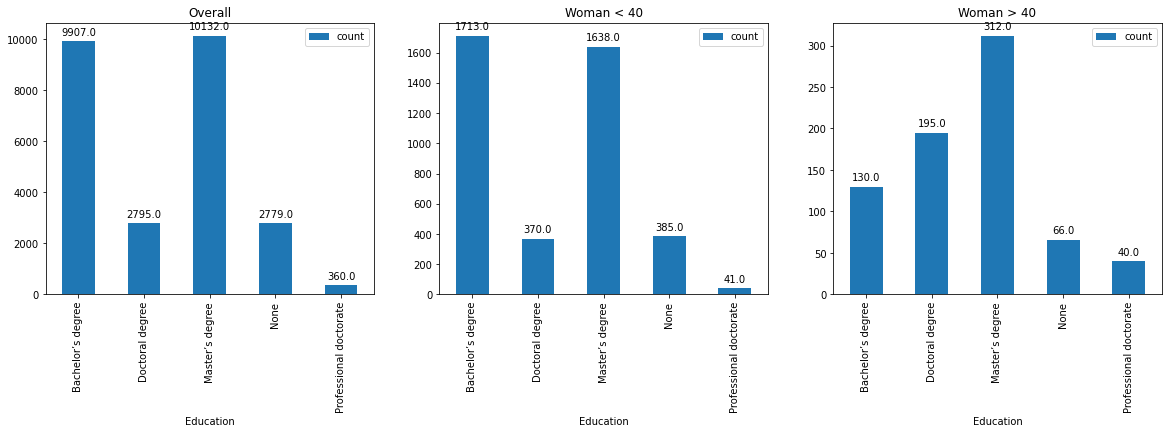

In [4284]:
COLS_EDU = ('Q4', 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?')
df[COLS_EDU].value_counts(normalize=True)*100

df_new['Education'] = df[COLS_EDU].apply(lambda x: 'None' if x in ['I prefer not to answer','No formal education past high school', 'Some college/university study without earning a bachelor’s degree'] else x )
getYYY(df_new, 'Education')

Overall and Woman<40 categories, the members mostly have Bachelor's & Masters degree followed by No degree, Doctor, Professional Doctor

**Women >40** have mostly **Masters degree** followed by Doctors, Bachelors, None and then Professional doctorate


Missing values: 0
Missing values: 0


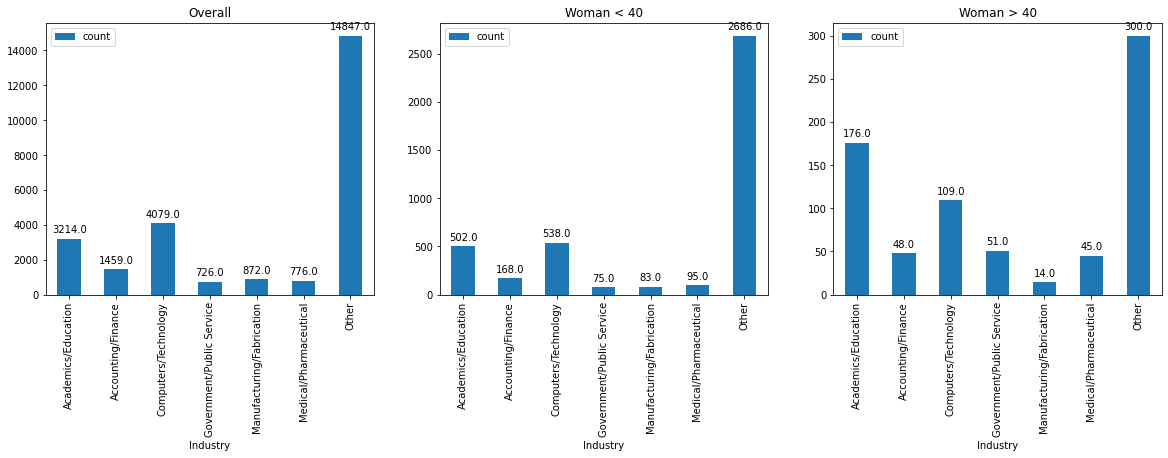

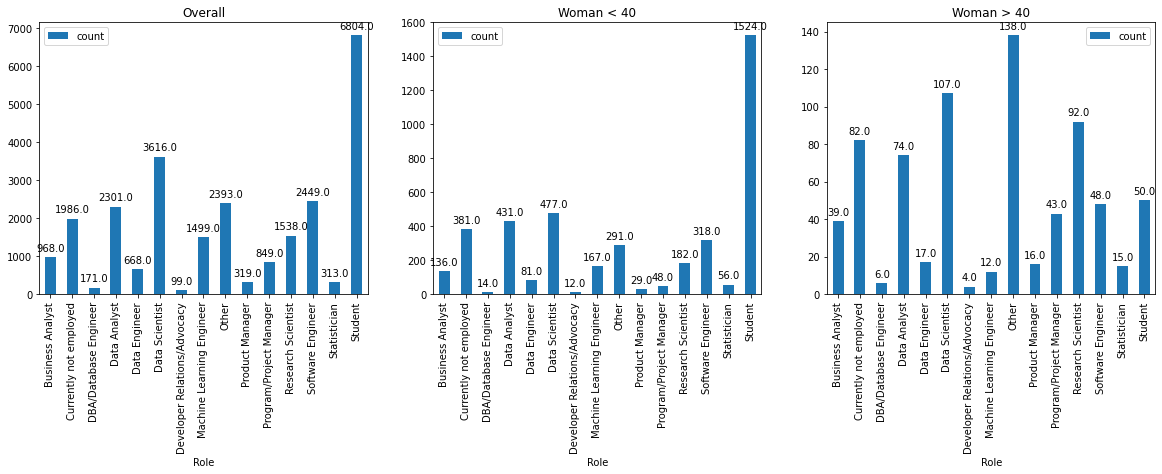

In [4285]:
COLS_INDUSTRY = ('Q20', 'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice')
df[COLS_INDUSTRY].value_counts(normalize=True)*100;print()
df_new['Industry'] = df[COLS_INDUSTRY].apply(lambda x: x if x in ['Computers/Technology','Academics/Education', 'Accounting/Finance', 'Manufacturing/Fabrication', 'Medical/Pharmaceutical', 'Government/Public Service'] else 'Other' )
getYYY(df_new, 'Industry')

COLS_ROLE = ('Q5', 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice')
df[COLS_ROLE].value_counts(normalize=True)*100
df_new['Role'] = df[COLS_ROLE]
getYYY(df_new, 'Role')

Higher percentage of the women > 40yrs are in the Academics/Education followed by Computers/Technology. These are similar in the overall and women < 40 yrs but much higher percentages

Missing values: 10582


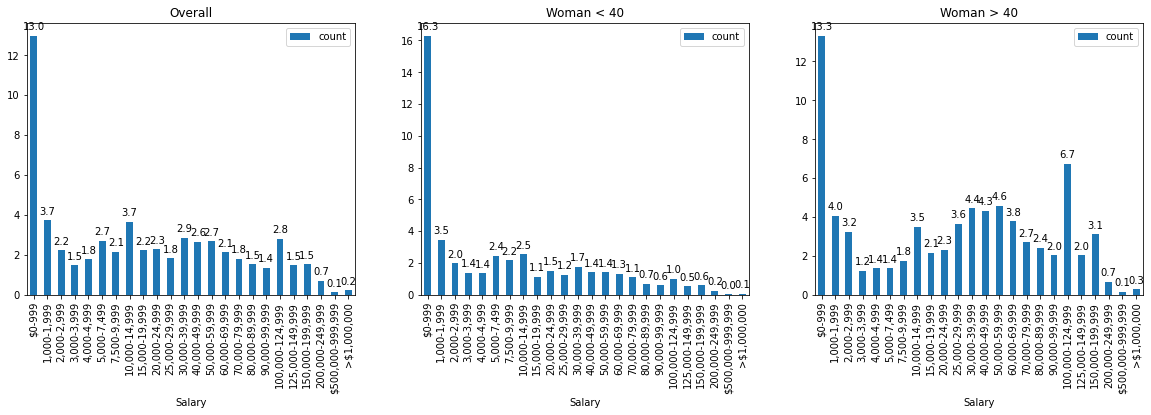

In [4329]:
COLS_SAL = ('Q25', 'What is your current yearly compensation (approximate $USD)?')
df[COLS_SAL].value_counts(normalize=True).sort_values(ascending=False)
df_new['Salary'] = df[COLS_SAL]
#getYYY(df_new, 'Salary')

col = 'Salary'
cols = ['Age','Gender','AgeGroup',col]
print("Missing values:", df_new[col].isnull().sum())
#print(df_[cols].head())

SAL_VALUES = ['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499', '7,500-9,999','10,000-14,999', '15,000-19,999', '20,000-24,999','25,000-29,999', '30,000-39,999', '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999', '90,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-199,999','200,000-249,999', '$500,000-999,999', '>$1,000,000']
df_ = df_new
total = df_.shape[0]
df_all = df_[cols].groupby(by=[col]).agg({col: 'count'})
df_all.rename(columns={col:'count'}, inplace=True)
df_all = df_all.reindex(SAL_VALUES)
df_all.reset_index(inplace=True)
df_all['count'] = round((df_all['count']/total)*100,2)
#print(df_all)

df_ = df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')]
total = df_.shape[0]
df_wlt40 = df_[cols].groupby(by=[col]).agg({col: 'count'})
df_wlt40.rename(columns={col:'count'}, inplace=True)
df_wlt40 = df_wlt40.reindex(SAL_VALUES)
df_wlt40.reset_index(inplace=True)
df_wlt40['count'] = round((df_wlt40['count']/total)*100,2)
#print(df_wlt40)


df_ = df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')]
total = df_.shape[0]
df_wgt40 = df_[cols].groupby(by=[col]).agg({col: 'count'})
df_wgt40.rename(columns={col:'count'}, inplace=True)
df_wgt40 = df_wgt40.reindex(SAL_VALUES)
df_wgt40.reset_index(inplace=True)
df_wgt40['count'] = round((df_wgt40['count']/total)*100,2)
#print(df_wgt40)

plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 3, 1); ax = df_all.plot.bar(col, ax=ax); annotate(ax, 'Overall')
ax = plt.subplot(1, 3, 2); ax = df_wlt40.plot.bar(col, ax=ax); annotate(ax, 'Woman < 40')
ax = plt.subplot(1, 3, 3); ax = df_wgt40.plot.bar(col, ax=ax); annotate(ax, 'Woman > 40')

The salaries of the women > 40yrs is higher than their coutnerparts (owing to the experience)

## Development Toolset/Environment
Programming Languages, IDE, Tools, Frameworks

### Programming Languages

TODO: 
Do you want to show top 3 PLs for each group? 

COLS_PL       12: Q7_Part_1, Q7_Part_2, Q7_Part_3, Q7_Part_4, Q7_Part_5, Q7_Part_6, Q7_Part_7, Q7_Part_8, Q7_Part_9, Q7_Part_10, Q7_Part_11, Q7_OTHER, 
COLS_PL_TOP3   3: Q7_Part_1, Q7_Part_3, Q7_Part_5, 
COLS_PL_OTHER  9: Q7_Part_2, Q7_Part_4, Q7_Part_6, Q7_Part_7, Q7_Part_8, Q7_Part_9, Q7_Part_10, Q7_Part_11, Q7_OTHER, 
COLS_PL_NONE   1: Q7_Part_12, 


,Overall,"(<40, Woman)","(>40, Woman)"
PLPython,84.16,81.60,66.35
PLSQL,41.41,42.78,44.01
PLC++,21.31,20.91,14.13
PL-Other,11.73,11.35,11.35
PL-None,5.20,6.56,14.40


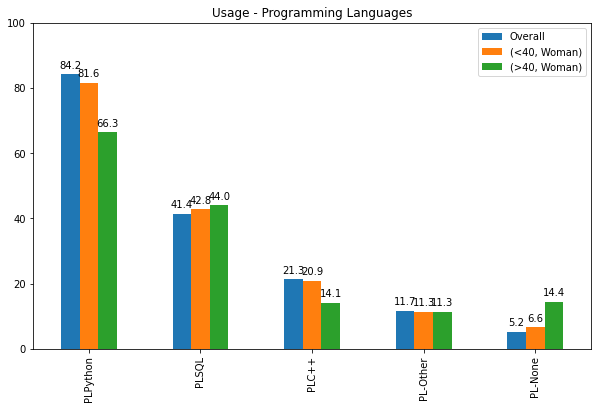

In [4287]:
plt.figure(figsize=(10, 6))

ax = plt.subplot(1,1 ,1)
CAT = "PL"; Q_PREFIX = "Q7"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}12'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}1', f'{CAT}Python', "Python",
            f'{Q_PART_PREFIX}3', f'{CAT}SQL', "SQL",
            f'{Q_PART_PREFIX}5', f'{CAT}C++', "C++", ax, 'Usage - Programming Languages') 

The trend of usage of Programming Languages for the Woman > 40 is similar to overall and Woman <40. The most used programming languages are in the order Python, SQL, C++

The python users in the Woman >40 is lesser than the rest.

The number of women > 40 not using any programming language is 14.4 which is significantly higher than the overall and women<40 category.

In [4288]:
print("cols", len(COLS_PL + COLS_PL_NONE))
print("Total rows: ", df.shape[0])
print("Rows with all COLS_PL + COLS_PL_NONE nulls:", df[df[COLS_PL + COLS_PL_NONE].isnull().sum(axis=1)==13].shape[0])
print("Rows with all COLS_PL nulls:", (df[df[COLS_PL].isnull().sum(axis=1)==12][COLS_PL_NONE]).shape[0]/df.shape[0]) #[COLS_PL_NONE].isnull().sum()
#print("XXX", df.loc[ df[COLS_PL].isnull().sum(axis=1)<12, : ][COLS_PL_NONE]=='None')
# print("Rows with all COLS_PL nulls:", df[(df[COLS_PL].isnull().sum(axis=1)==12)&(df[COLS_PL_NONE]=='None')].shape[0])

df_temp = df[df[COLS_PL].isnull().sum(axis=1)<12][COLS_PL_NONE]#)==True #][COLS_PL_NONE]
print(df_temp.shape[0])
df_temp[COLS_PL_NONE].value_counts()

cols 13
Total rows:  25973
Rows with all COLS_PL + COLS_PL_NONE nulls: 1032
Rows with all COLS_PL nulls: 0.05201555461440727
24622


Series([], dtype: int64)

In [4289]:
print(df_new['PLPython'].sum(), df_new[df_new['PLPython']==0]['PLPython'].count(), df_new.shape[0])
def abc(label, lt40, gt40):
    print(f"{label:5}    <40: {percent(lt40,df.shape[0]):2.2f}%    >40: {percent(gt40,df.shape[0]):2.2f}%")

abc("Woman", 4147, 743)
abc("Man", 15956, 4642)

21860 4113 25973
Woman    <40: 15.97%    >40: 2.86%
Man      <40: 61.43%    >40: 17.87%


In [ ]:
'''def my_value_counts(df, col):
    df_ = df['ProgLang'].value_counts(normalize=True).to_frame()
    #print(df_pl_all)
    return df_

df_pl_all = my_value_counts(df_new, 'ProgLang') 
df_pl_man = my_value_counts(df_man, 'ProgLang') 
df_pl_woman =  my_value_counts(df_woman, 'df_woman')
df_pl_woman_lt40 =  my_value_counts(df_woman[df_woman['AgeGroup']=='<40'], 'ProgLang') 
df_pl_woman_gt40 =  my_value_counts(df_woman[df_woman['AgeGroup']=='>40'], 'ProgLang') 
df_res = pd.merge(df_pl_man, df_pl_woman, left_index=True, right_index=True,suffixes=['_m','_w'])
df_res = pd.merge(df_res, df_pl_woman_lt40, left_index=True, right_index=True)
df_res = pd.merge(df_res, df_pl_woman_gt40, left_index=True, right_index=True,suffixes=['_w_lt40','_w_gt40'])
df_res = pd.merge(df_pl_all, df_res, left_index=True, right_index=True)
round(df_res*100,1)
df_res.plot.bar(figsize=(15,5), logy=True)'''

### IDEs & Hosted Notebooks
TODO: Place them in 1 row

COLS_IDE       12: Q9_Part_1, Q9_Part_2, Q9_Part_3, Q9_Part_4, Q9_Part_5, Q9_Part_6, Q9_Part_7, Q9_Part_8, Q9_Part_9, Q9_Part_10, Q9_Part_11, Q9_OTHER, 
COLS_IDE_TOP3   3: Q9_Part_11, Q9_Part_4, Q9_Part_5, 
COLS_IDE_OTHER  9: Q9_Part_1, Q9_Part_2, Q9_Part_3, Q9_Part_6, Q9_Part_7, Q9_Part_8, Q9_Part_9, Q9_Part_10, Q9_OTHER, 
COLS_IDE_NONE   1: Q9_Part_12, 
COLS_IDE       16: Q10_Part_1, Q10_Part_2, Q10_Part_3, Q10_Part_4, Q10_Part_5, Q10_Part_6, Q10_Part_7, Q10_Part_8, Q10_Part_9, Q10_Part_10, Q10_Part_11, Q10_Part_12, Q10_Part_13, Q10_Part_14, Q10_Part_15, Q10_OTHER, 
COLS_IDE_TOP3   3: Q10_Part_2, Q10_Part_1, Q10_Part_10, 
COLS_IDE_OTHER 13: Q10_Part_3, Q10_Part_4, Q10_Part_5, Q10_Part_6, Q10_Part_7, Q10_Part_8, Q10_Part_9, Q10_Part_11, Q10_Part_12, Q10_Part_13, Q10_Part_14, Q10_Part_15, Q10_OTHER, 
COLS_IDE_NONE   1: Q10_Part_16, 


,Overall,"(<40, Woman)","(>40, Woman)"
HNB-Colab,37.70,35.01,28.26
HNB-Kaggle,36.60,34.63,26.51
HNB-Google,7.90,7.76,6.46
HNB-Other,2.71,2.63,2.68
HNB-None,32.10,33.11,43.61


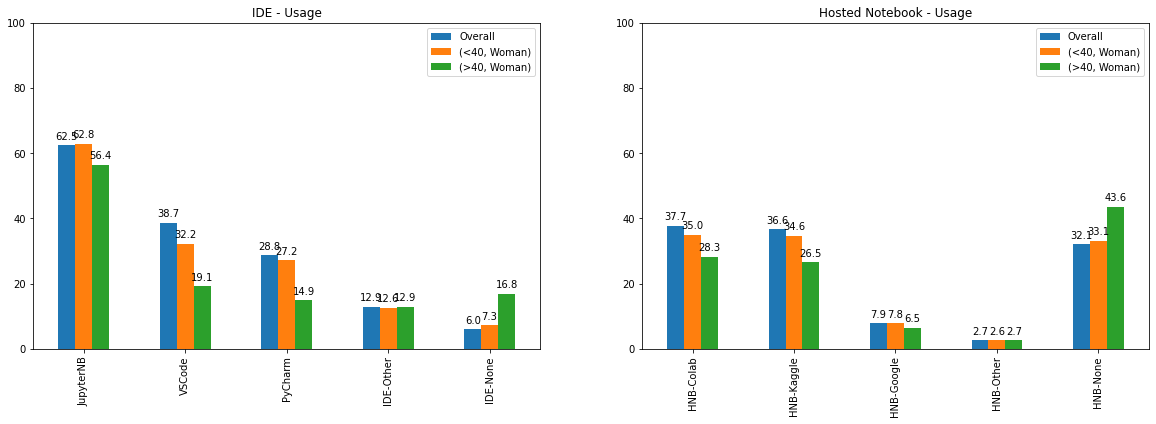

In [4290]:
plt.figure(figsize=(20, 6))

COLS_IDE, COLS_IDE_TOP3, COLS_IDE_OTHER, COLS_IDE_NONE = getCols('IDE',  'Q9', 'Q9_Part_12', )
df[COLS_IDE].head()
ax = plt.subplot(1, 2, 1)
summarise(df, df_new, 'IDE', COLS_IDE, COLS_IDE_OTHER,             'Q9_Part_12',
            'Q9_Part_11', 'JupyterNB', "Jupyter Notebook",
            'Q9_Part_4', 'VSCode', "Visual Studio Code (VSCode)",
            'Q9_Part_5', 'PyCharm', "PyCharm", ax, title = "IDE - Usage")

COLS_HNB, COLS_HNB_TOP3, COLS_HNB_OTHER, COLS_HNB_NONE = getCols('IDE',  'Q10', 'Q10_Part_16', )
df[COLS_HNB].head()
ax = plt.subplot(1, 2, 2)
summarise(df, df_new, 'HNB', COLS_HNB, COLS_HNB_OTHER, 'Q10_Part_16',
            'Q10_Part_2', 'HNB-Colab', "Colab Notebooks",
            'Q10_Part_1', 'HNB-Kaggle', "Kaggle Notebooks",
            'Q10_Part_10', 'HNB-Google', "Google Cloud Notebooks (AI Platform / Vertex AI)", ax, title = "Hosted Notebook - Usage" )

The trend across categories in the **IDE** and **Hosted Notebook** usage is similar. The most used IDEs are Jupyter Notebook, VS Code and PyCharm

The number of women > 40 not using any IDE and Hosted Notebook is 16.8 and 43.6 respectively which is again significantly higher than the overall and women<40 category.

### PL & ML Usage

In [4291]:
COLS_ML_USE = ('Q15','For how many years have you used machine learning methods?')
print(df[COLS_ML_USE].value_counts(normalize=True)*100);print()

COLS_PL_USE = ('Q6', 'For how many years have you been writing code and/or programming?')
print(df[COLS_PL_USE].value_counts(normalize=True)*100)

df_new['MLUsage'] = df[COLS_ML_USE].apply(lambda x: '0 years' if x == 'I do not use machine learning methods' else x )
df_new['PLUsage'] = df[COLS_PL_USE].apply(lambda x: '0 years' if x == 'I have never written code' else x)

COLS_USAGE = ['Age','Gender','AgeGroup','PL-Count','MLUsage','PLUsage']
df_new[COLS_USAGE].head()

Under 1 year                             38.574556
1-2 years                                19.680896
I do not use machine learning methods    16.371979
2-3 years                                 9.703629
3-4 years                                 4.929696
5-10 years                                4.348741
4-5 years                                 3.978277
10-20 years                               1.523954
20 or more years                          0.888271
Name: (Q15, For how many years have you used machine learning methods?), dtype: float64

1-3 years                    30.316097
< 1 years                    22.642744
3-5 years                    15.635468
5-10 years                   11.931621
10-20 years                   8.339429
20+ years                     7.161283
I have never written code     3.973357
Name: (Q6, For how many years have you been writing code and/or programming?), dtype: float64


,Age,Gender,AgeGroup,PL-Count,MLUsage,PLUsage
0,50-54,Man,>40,2,5-10 years,5-10 years
1,50-54,Man,>40,4,Under 1 year,20+ years
2,22-24,Man,<40,3,0 years,1-3 years
3,45-49,Man,>40,1,5-10 years,20+ years
4,45-49,Man,>40,3,10-20 years,< 1 years


In [4292]:
def plotMLPLUsage(df, ax, title):
    df.rename(columns={'MLUsage':'Count'},inplace=True)
    df.reset_index(inplace=True)
    #print(df.sort_values(by=['MLUsage','PLUsage']).head())
    #print(df[df['MLUsage'] == '20 or more years'])

    df_mlpl = pd.pivot_table(df, index=['PLUsage'], columns = ['MLUsage'], values ='Count', aggfunc=np.sum)
    df_mlpl = df_mlpl[['0 years', 'Under 1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-20 years', '20 or more years']]
    df_mlpl = df_mlpl.reindex(index = ['< 1 years', '1-3 years','3-5 years', '5-10 years', '10-20 years', '20+ years'] )
    
    #fig, ax = plt.subplots(figsize=(10,8)) 
    if ax is None: 
        sns.heatmap(df_mlpl, annot=True, fmt="g", cmap="YlGnBu")
    else:
        sns.heatmap(df_mlpl, annot=True, fmt="g", ax=ax, cmap="YlGnBu")

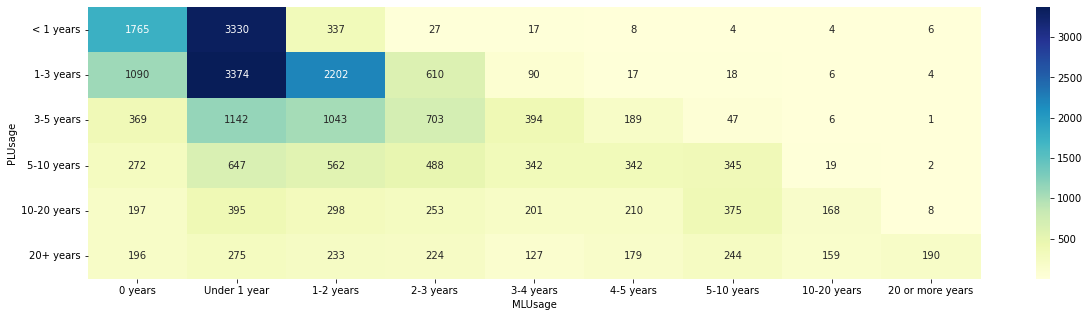

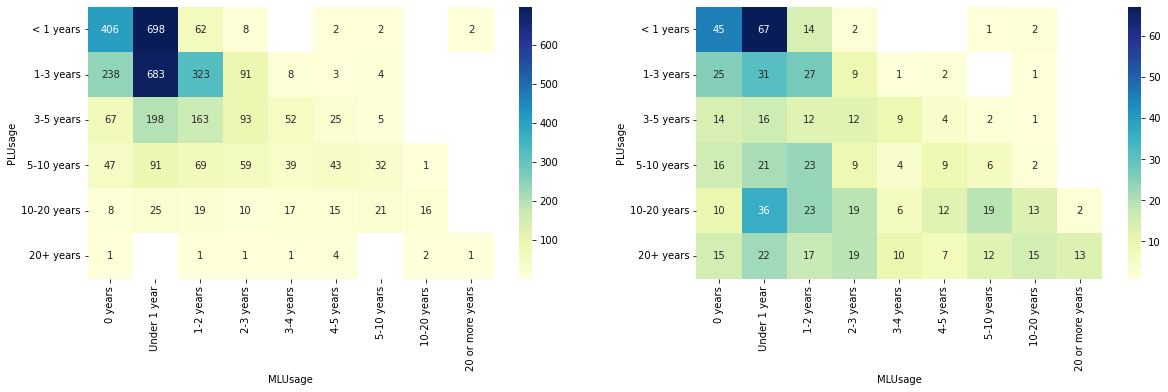

In [4293]:
df_all = df_new[COLS_USAGE].groupby(by=['MLUsage','PLUsage']).agg({ 'MLUsage': 'count'})
df_wlt40 = df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')][COLS_USAGE].groupby(by=['MLUsage','PLUsage']).agg({ 'MLUsage': 'count'})
df_wgt40 = df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')][COLS_USAGE].groupby(by=['MLUsage','PLUsage']).agg({ 'MLUsage': 'count'})

plt.figure(figsize=(20, 5))
plotMLPLUsage(df_all, None, 'Overall');plt.show()

plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 2, 1); plotMLPLUsage(df_wlt40, ax, 'Woman < 40')
ax = plt.subplot(1, 2, 2); plotMLPLUsage(df_wgt40, ax, 'Woman > 40')

Most of the **overall** and **woman <40 years** communities have been using programming languages for **< 5 years** and have been using ML for **< 3 years**. CVery few have been using Programming Languages and ML beyond these numbers.

For obvious reasons, the **woman > 40** community has been using programming languages and ML for more years than their coutnerparts.

### Data Visualization & Machine Learning Framework

COLS_Viz       11: Q14_Part_1, Q14_Part_2, Q14_Part_3, Q14_Part_4, Q14_Part_5, Q14_Part_6, Q14_Part_7, Q14_Part_8, Q14_Part_9, Q14_Part_10, Q14_OTHER, 
COLS_Viz_TOP3   3: Q14_Part_1, Q14_Part_2, Q14_Part_3, 
COLS_Viz_OTHER  8: Q14_Part_4, Q14_Part_5, Q14_Part_6, Q14_Part_7, Q14_Part_8, Q14_Part_9, Q14_Part_10, Q14_OTHER, 
COLS_Viz_NONE   1: Q14_Part_11, 
COLS_MLFW       17: Q16_Part_1, Q16_Part_2, Q16_Part_3, Q16_Part_4, Q16_Part_5, Q16_Part_6, Q16_Part_7, Q16_Part_8, Q16_Part_9, Q16_Part_10, Q16_Part_11, Q16_Part_12, Q16_Part_13, Q16_Part_14, Q16_Part_15, Q16_Part_16, Q16_OTHER, 
COLS_MLFW_TOP3   3: Q16_Part_1, Q16_Part_2, Q16_Part_3, 
COLS_MLFW_OTHER 14: Q16_Part_4, Q16_Part_5, Q16_Part_6, Q16_Part_7, Q16_Part_8, Q16_Part_9, Q16_Part_10, Q16_Part_11, Q16_Part_12, Q16_Part_13, Q16_Part_14, Q16_Part_15, Q16_Part_16, Q16_OTHER, 
COLS_MLFW_NONE   1: Q16_Part_17, 


,Overall,"(<40, Woman)","(>40, Woman)"
MLFW-Scikit-learn,53.85,46.90,48.18
MLFW-TensorFlow,36.08,28.57,25.44
MLFW-Keras,30.70,24.26,22.07
MLFW-Other,6.34,4.26,5.10
MLFW-None,31.82,41.52,39.17


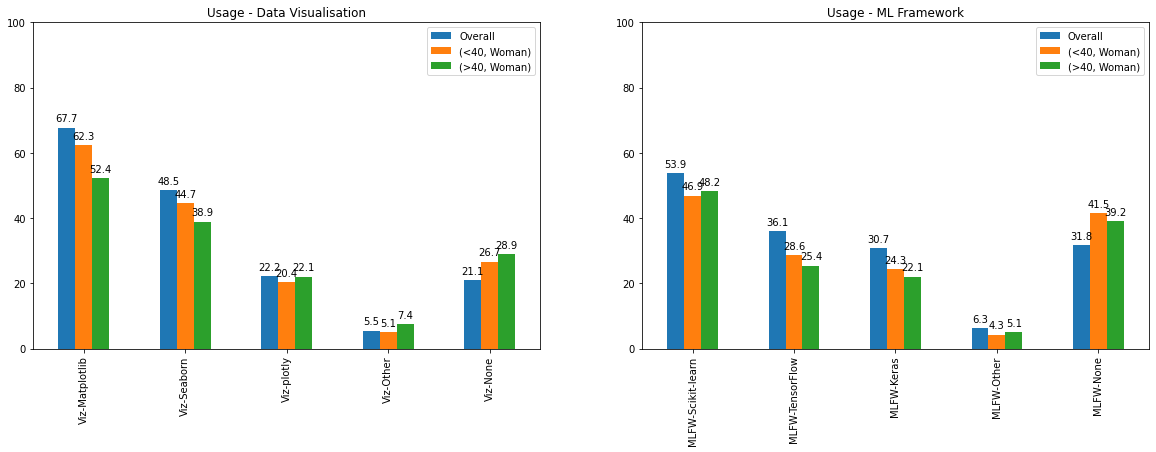

In [4294]:
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
COLS_VIZ, COLS_VIZ_TOP3, COLS_VIZ_OTHER, COLS_VIZ_NONE = getCols('Viz',  'Q14', 'Q14_Part_11', )
df[COLS_VIZ].head()
summarise(df, df_new, 'Viz', COLS_VIZ, COLS_VIZ_OTHER, 'Q14_Part_11',
            'Q14_Part_1', 'Viz-Matplotlib', "Matplotlib",
            'Q14_Part_2', 'Viz-Seaborn', "Seaborn",
            'Q14_Part_3', 'Viz-plotly', "Plotly / Plotly Express", ax, "Usage - Data Visualisation"
            )

ax = plt.subplot(1, 2, 2)
COLS_MLFW, COLS_MLFW_TOP3, COLS_MLFW_OTHER, COLS_MLFW_NONE = getCols('MLFW',  'Q16', 'Q16_Part_17', )
df[COLS_MLFW].head()
summarise(df, df_new, 'MLFW', COLS_MLFW, COLS_MLFW_OTHER, 'Q16_Part_17',
            'Q16_Part_1', 'MLFW-Scikit-learn', "Scikit-learn",
            'Q16_Part_2', 'MLFW-TensorFlow', "TensorFlow",
            'Q16_Part_3', 'MLFW-Keras', "Keras", ax, "Usage - ML Framework"
            )

matplotlib, seaborn, plotly are most used visualization libraries

scikit learn, tensorflow and keras are most used for general machine learning frameworks

## Machine Learning Concepts, Practices
Algorithms, CV, NLP, AutoML

### ML Algorithm, Computer Vision, Natural Language Processing (NLP)

COLS_MLA       11: Q17_Part_1, Q17_Part_2, Q17_Part_3, Q17_Part_4, Q17_Part_5, Q17_Part_6, Q17_Part_7, Q17_Part_8, Q17_Part_9, Q17_Part_10, Q17_OTHER, 
COLS_MLA_TOP3   3: Q17_Part_1, Q17_Part_2, Q17_Part_3, 
COLS_MLA_OTHER  8: Q17_Part_4, Q17_Part_5, Q17_Part_6, Q17_Part_7, Q17_Part_8, Q17_Part_9, Q17_Part_10, Q17_OTHER, 
COLS_MLA_NONE   1: Q17_Part_11, 
COLS_CV        6: Q18_Part_1, Q18_Part_2, Q18_Part_3, Q18_Part_4, Q18_Part_5, Q18_OTHER, 
COLS_CV_TOP3   3: Q18_Part_4, Q18_Part_2, Q18_Part_3, 
COLS_CV_OTHER  3: Q18_Part_1, Q18_Part_5, Q18_OTHER, 
COLS_CV_NONE   1: Q18_Part_6, 
COLS_NLP        5: Q19_Part_1, Q19_Part_2, Q19_Part_3, Q19_Part_4, Q19_OTHER, 
COLS_NLP_TOP3   3: Q19_Part_1, Q19_Part_4, Q19_Part_2, 
COLS_NLP_OTHER  2: Q19_Part_3, Q19_OTHER, 
COLS_NLP_NONE   1: Q19_Part_5, 


,Overall,"(<40, Woman)","(>40, Woman)"
NLP Word embeddings,10.18,6.56,8.61
NLP Encoder-decorder models,0.00,0.00,0.00
NLP Transformer language models,0.00,0.00,0.00
NLP-Other,1.65,1.19,1.88
NLP-None,85.20,90.14,88.56


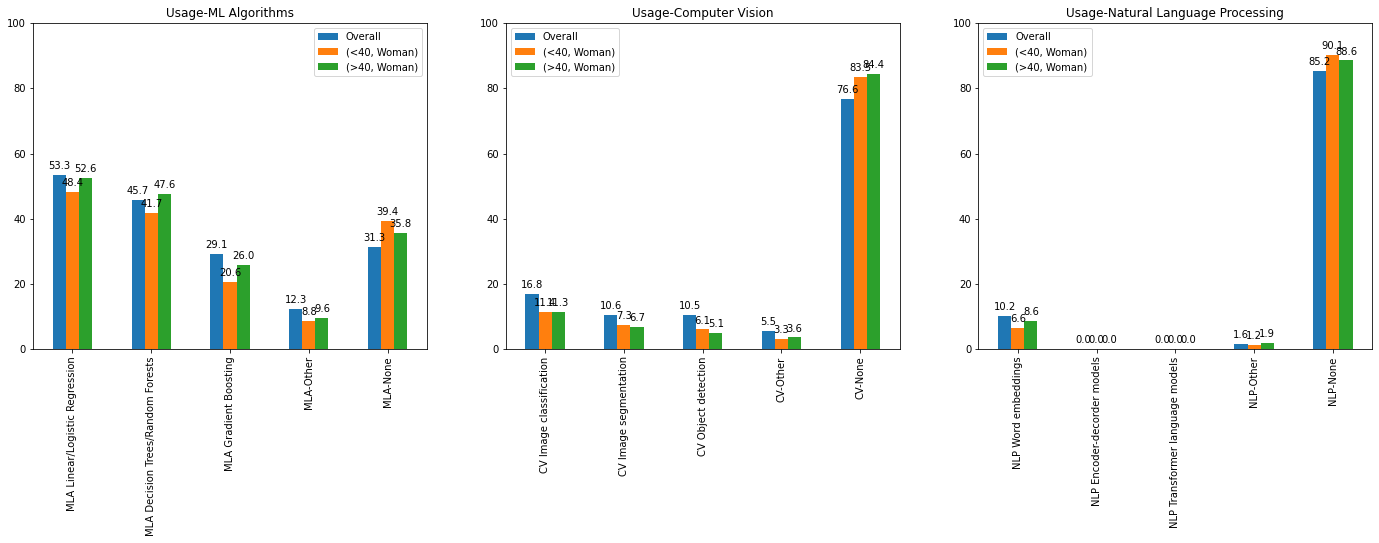

In [4295]:
plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
CAT, Q_PREFIX = "MLA", "Q17"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}11'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}1', f'{CAT} Linear/Logistic Regression', "Linear or Logistic Regression",
            f'{Q_PART_PREFIX}2', f'{CAT} Decision Trees/Random Forests', "Decision Trees or Random Forests",
            f'{Q_PART_PREFIX}3', f'{CAT} Gradient Boosting', "Gradient Boosting Machines (xgboost, lightgbm, etc)", ax=ax, title="Usage-ML Algorithms") 

ax = plt.subplot(1, 3, 2)
CAT, Q_PREFIX = "CV", "Q18"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}6'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}4', f'{CAT} Image classification', "Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)",
            f'{Q_PART_PREFIX}2', f'{CAT} Image segmentation', "Image segmentation methods (U-Net, Mask R-CNN, etc)",
            f'{Q_PART_PREFIX}3', f'{CAT} Object detection', "Object detection methods (YOLOv3, RetinaNet, etc)", ax=ax, title="Usage-Computer Vision") 

ax = plt.subplot(1, 3, 3)
CAT, Q_PREFIX  = "NLP", "Q19"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}5'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}1', f'{CAT} Word embeddings', "Word embeddings/vectors (GLoVe, fastText, word2vec)",
            f'{Q_PART_PREFIX}4', f'{CAT} Encoder-decorder models', "Encoder-decorder models (seq2seq, vanilla transformers)",
            f'{Q_PART_PREFIX}2', f'{CAT} Transformer language models', "Transformer language models (GPT-3, BERT, XLnet, etc)", ax=ax, title="Usage-Natural Language Processing") 

### AutoML

COLS_AML        7: Q36_A_Part_1, Q36_A_Part_2, Q36_A_Part_3, Q36_A_Part_4, Q36_A_Part_5, Q36_A_Part_6, Q36_A_OTHER, 
COLS_AML_TOP3   3: Q36_A_Part_3, Q36_A_Part_1, Q36_A_Part_5, 
COLS_AML_OTHER  4: Q36_A_Part_2, Q36_A_Part_4, Q36_A_Part_6, Q36_A_OTHER, 
COLS_AML_NONE   1: Q36_A_Part_7, 


,Overall,"(<40, Woman)","(>40, Woman)"
AMLAutomated model selection,4.57,2.72,4.17
AMLAutomated data augmentation,3.88,2.10,2.29
AMLAutomated hyperparameter tuning,3.67,1.40,2.29
AML-Other,2.15,1.12,2.05
AML-None,88.54,93.20,89.91


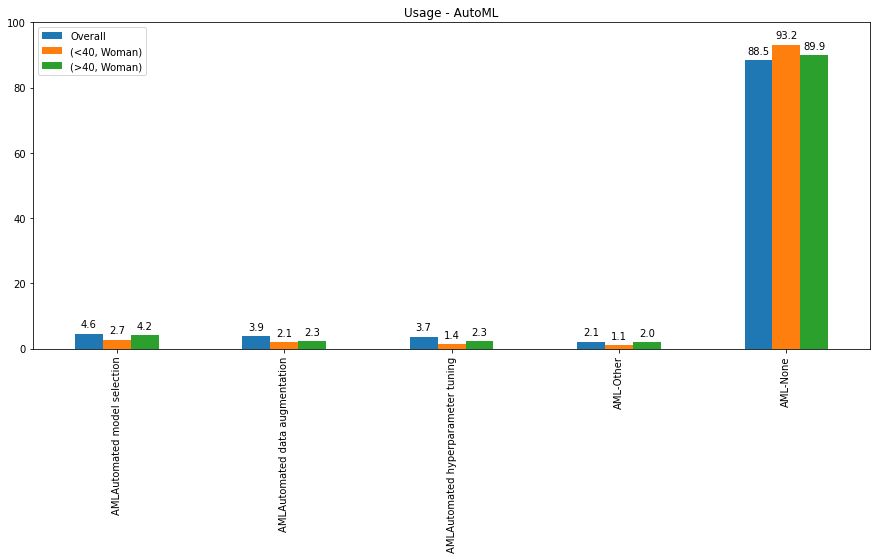

In [4296]:
plt.figure(figsize=(15, 6))

ax = plt.subplot(1, 1, 1)
CAT = "AML"; Q_PREFIX = "Q36_A"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}7'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}3', f'{CAT}Automated model selection', "Automated model selection (e.g. auto-sklearn, xcessiv)",
            f'{Q_PART_PREFIX}1', f'{CAT}' + 'Automated data augmentation', "Automated data augmentation (e.g. imgaug, albumentations)",
            f'{Q_PART_PREFIX}5', f'{CAT}' + 'Automated hyperparameter tuning', "Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)", 
            ax, title='Usage - AutoML') 

In the areas of ML algorithms, CV and NLP, women > 40 yrs follow a similar pattern as their counterparts.

## Managed Platforms & Products 
Cloud Computing Platforms, Cloud Computing Products
Big Data Products, Data Storage Products
BI Tools
Maanged ML Products, Manage Machine Learning Experiments

### Hardware, Cloud Computing Platform, Cloud Computing Products

COLS_HW        5: Q12_Part_1, Q12_Part_2, Q12_Part_3, Q12_Part_4, Q12_OTHER, 
COLS_HW_TOP3   3: Q12_Part_1, Q12_Part_2, Q12_OTHER, 
COLS_HW_OTHER  2: Q12_Part_3, Q12_Part_4, 
COLS_HW_NONE   1: Q12_Part_5, 
COLS_CCPLT       11: Q27_A_Part_1, Q27_A_Part_2, Q27_A_Part_3, Q27_A_Part_4, Q27_A_Part_5, Q27_A_Part_6, Q27_A_Part_7, Q27_A_Part_8, Q27_A_Part_9, Q27_A_Part_10, Q27_A_OTHER, 
COLS_CCPLT_TOP3   3: Q27_A_Part_1, Q27_A_Part_3, Q27_A_Part_2, 
COLS_CCPLT_OTHER  8: Q27_A_Part_4, Q27_A_Part_5, Q27_A_Part_6, Q27_A_Part_7, Q27_A_Part_8, Q27_A_Part_9, Q27_A_Part_10, Q27_A_OTHER, 
COLS_CCPLT_NONE   1: Q27_A_Part_11, 
COLS_CCP        4: Q29_A_Part_1, Q29_A_Part_2, Q29_A_Part_3, Q29_A_OTHER, 
COLS_CCP_TOP3   3: Q29_A_Part_1, Q29_A_Part_3, Q29_A_Part_2, 
COLS_CCP_OTHER  1: Q29_A_OTHER, 
COLS_CCP_NONE   1: Q29_A_Part_4, 


,Overall,"(<40, Woman)","(>40, Woman)"
CCP-AWSEC2,8.74,4.32,6.59
CCP-GCCE,7.55,0.10,1.14
CCP-Other,0.38,0.29,0.27
CCP-None,82.91,90.67,83.98


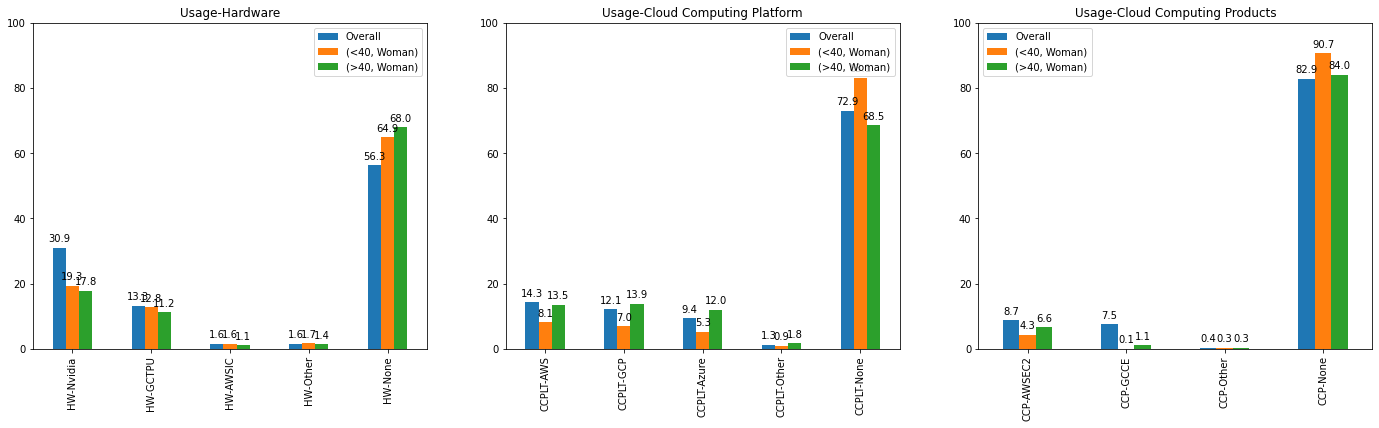

In [4308]:
plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
COLS_HW, COLS_HW_TOP3, COLS_HW_OTHER, COLS_HW_NONE = getCols('HW',  'Q12', 'Q12_Part_5', )
df[COLS_HW].head()
summarise(df, df_new, 'HW', COLS_HW, COLS_HW_OTHER, 'Q12_Part_5',
            'Q12_Part_1', 'HW-Nvidia', "NVIDIA GPUs",
            'Q12_Part_2', 'HW-GCTPU', "Google Cloud TPUs",
            'Q12_Part_4', 'HW-AWSIC', "AWS Inferentia Chips", ax, title="Usage-Hardware")

ax = plt.subplot(1, 3, 2)
CAT = "CCPLT"
COL_NONE = 'Q27_A_Part_11'
COLS, _, COLS_OTHER, _ = getCols(CAT,  'Q27_A', COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            'Q27_A_Part_1', 'CCPLT-AWS', "Amazon Web Services (AWS)",
            'Q27_A_Part_3', 'CCPLT-GCP', "Google Cloud Platform (GCP)",
            'Q27_A_Part_2', 'CCPLT-Azure', "Microsoft Azure", ax, title="Usage-Cloud Computing Platform")

# TODO: None comes in top 3 so the plot is screwed up   
ax = plt.subplot(1, 3, 3)        
CAT = "CCP"
COL_NONE = 'Q29_A_Part_4'
COLS, _, COLS_OTHER, _ = getCols(CAT,  'Q29_A', COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            'Q29_A_Part_1', 'CCP-AWSEC2', "Amazon Elastic Compute Cloud (EC2)",
            'Q29_A_Part_3', 'CCP-GCCE', "Google Cloud Compute Engine",
            'Q29_A_Part_3', 'CCP-GCCE', "Google Cloud Compute Engine",
            ax, title="Usage-Cloud Computing Products") 

- Similar trend across categories in the Hardware as well. The most used Hosted NBs are Nvidia, GC TPU, AWS IC. The number of people not using any Hardware is lot more than those who are using specific Harward.
- The number of women > 40 not using specific Hardware is similar to the overall numbers.

### Managed Machine Learning Products, Auto ML Tools, Manage Machine Learning Experiments

COLS_MMLP        9: Q31_A_Part_1, Q31_A_Part_2, Q31_A_Part_3, Q31_A_Part_4, Q31_A_Part_5, Q31_A_Part_6, Q31_A_Part_7, Q31_A_Part_8, Q31_A_OTHER, 
COLS_MMLP_TOP3   3: Q31_A_Part_1, Q31_A_Part_2, Q31_A_Part_5, 
COLS_MMLP_OTHER  6: Q31_A_Part_3, Q31_A_Part_4, Q31_A_Part_6, Q31_A_Part_7, Q31_A_Part_8, Q31_A_OTHER, 
COLS_MMLP_NONE   1: Q31_A_Part_9, 
COLS_ATML        7: Q37_A_Part_1, Q37_A_Part_2, Q37_A_Part_3, Q37_A_Part_4, Q37_A_Part_5, Q37_A_Part_6, Q37_A_OTHER, 
COLS_ATML_TOP3   3: Q37_A_Part_1, Q37_A_Part_6, Q37_A_Part_5, 
COLS_ATML_OTHER  4: Q37_A_Part_2, Q37_A_Part_3, Q37_A_Part_4, Q37_A_OTHER, 
COLS_ATML_NONE   1: Q37_A_Part_7, 
COLS_MLEXP        8: Q37_A_Part_1, Q37_A_Part_2, Q37_A_Part_3, Q37_A_Part_4, Q37_A_Part_5, Q37_A_Part_6, Q37_A_Part_7, Q37_A_OTHER, 
COLS_MLEXP_TOP3   3: Q37_A_Part_7, Q37_A_Part_1, Q37_A_Part_6, 
COLS_MLEXP_OTHER  5: Q37_A_Part_2, Q37_A_Part_3, Q37_A_Part_4, Q37_A_Part_5, Q37_A_OTHER, 
COLS_MLEXP_NONE   1: Q38_A_Part_11, 


,Overall,"(<40, Woman)","(>40, Woman)"
MLEXP-Polyaxon,0.42,0.36,0.27
MLEXP-Neptune,0.84,0.48,0.67
MLEXP-Guild,0.46,0.41,0.40
MLEXP-Other,1.16,0.62,1.16
MLEXP-None,88.62,93.22,90.04


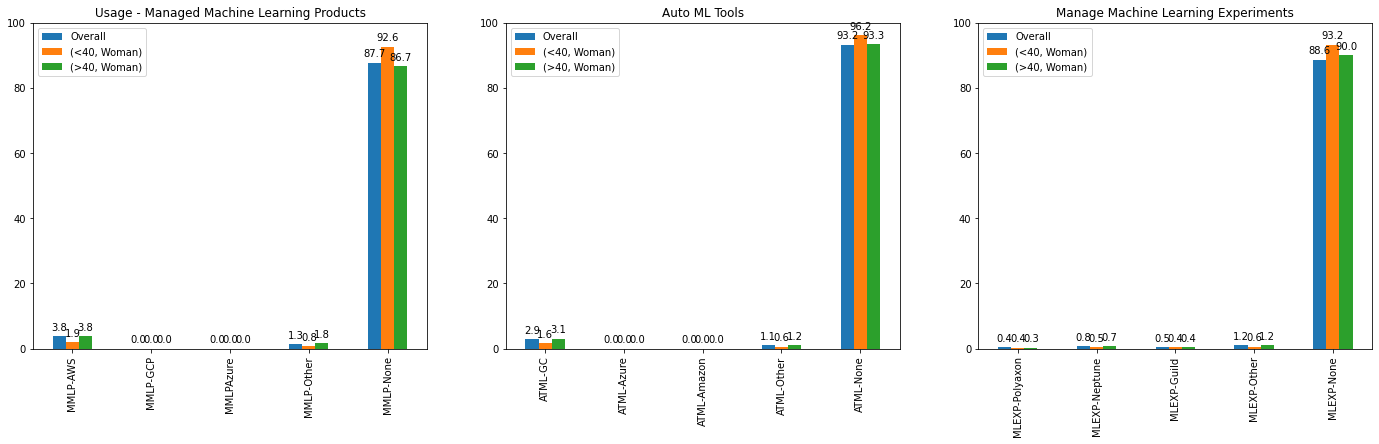

In [4298]:
plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
CAT = "MMLP";COL_NONE = 'Q31_A_Part_9'
COLS, _, COLS_OTHER, _ = getCols(CAT,  'Q31_A', COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            'Q31_A_Part_1', 'MMLP-AWS', "Amazon SageMaker",
            'Q31_A_Part_3', 'MMLP-GCP', "Azure Machine Learning Studio",
            'Q31_A_Part_2', 'MMLPAzure', "Databricks", ax, "Usage - Managed Machine Learning Products") 

ax = plt.subplot(1, 3, 2)
CAT = "ATML"; COL_NONE = 'Q37_A_Part_7'
COLS, _, COLS_OTHER, _ = getCols(CAT,  'Q37_A', COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            'Q37_A_Part_1', CAT+ '-' + 'GC', "Google Cloud AutoML",
            'Q37_A_Part_3', CAT+ '-' + 'Azure', "Azure Automated Machine Learning",
            'Q37_A_Part_2', CAT+ '-' + 'Amazon', "Amazon Sagemaker Autopilot", ax, "Auto ML Tools") 

ax = plt.subplot(1, 3, 3)
CAT = "MLEXP"; COL_NONE = 'Q38_A_Part_11'
COLS, _, COLS_OTHER, _ = getCols(CAT,  'Q37_A', COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            'Q38_A_Part_7', CAT+ '-' + 'Polyaxon', "Polyaxon",
            'Q38_A_Part_1', CAT+ '-' + 'Neptune', "Neptune.ai",
            'Q38_A_Part_6', CAT+ '-' + 'Guild', "Guild.ai", ax, "Manage Machine Learning Experiments" ) 

The adoption of these higher end platforms is very very less!

In [ ]:
CAT = "MLEXP"
COL_NONE = 'Q38_A_Part_11'

COLS, _, COLS_OTHER, _ = getCols(CAT,  'Q37_A', COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            'Q38_A_Part_7', CAT+ '-' + 'Polyaxon', "Polyaxon",
            'Q38_A_Part_1', CAT+ '-' + 'Neptune', "Neptune.ai",
            'Q38_A_Part_6', CAT+ '-' + 'Guild', "Guild.ai", ) 

### Data Storage Products, Big Data Product, Business Intelligence Tools

COLS_DSP        7: Q30_A_Part_1, Q30_A_Part_2, Q30_A_Part_3, Q30_A_Part_4, Q30_A_Part_5, Q30_A_Part_6, Q30_A_OTHER, 
COLS_DSP_TOP3   3: Q30_A_Part_3, Q30_A_Part_5, Q30_A_Part_1, 
COLS_DSP_OTHER  4: Q30_A_Part_2, Q30_A_Part_4, Q30_A_Part_6, Q30_A_OTHER, 
COLS_DSP_NONE   1: Q30_A_Part_7, 
COLS_BDP       20: Q32_A_Part_1, Q32_A_Part_2, Q32_A_Part_3, Q32_A_Part_4, Q32_A_Part_5, Q32_A_Part_6, Q32_A_Part_7, Q32_A_Part_8, Q32_A_Part_9, Q32_A_Part_10, Q32_A_Part_11, Q32_A_Part_12, Q32_A_Part_13, Q32_A_Part_14, Q32_A_Part_15, Q32_A_Part_16, Q32_A_Part_17, Q32_A_Part_18, Q32_A_Part_19, Q32_A_OTHER, 
COLS_BDP_TOP3   3: Q32_A_Part_1, Q32_A_Part_2, Q32_A_Part_8, 
COLS_BDP_OTHER 17: Q32_A_Part_3, Q32_A_Part_4, Q32_A_Part_5, Q32_A_Part_6, Q32_A_Part_7, Q32_A_Part_9, Q32_A_Part_10, Q32_A_Part_11, Q32_A_Part_12, Q32_A_Part_13, Q32_A_Part_14, Q32_A_Part_15, Q32_A_Part_16, Q32_A_Part_17, Q32_A_Part_18, Q32_A_Part_19, Q32_A_OTHER, 
COLS_BDP_NONE   1: Q32_A_Part_20, 
COLS_BIT       16: Q34_A_Part_1, Q34_A_

,Overall,"(<40, Woman)","(>40, Woman)"
BIT-Tableau,9.87,7.60,13.59
BIT-PowerBI,9.26,5.45,12.65
BIT-GoogleDataStudio,3.54,2.15,3.77
BIT-Other,0.91,0.58,1.15
BIT-None,79.69,85.72,75.50


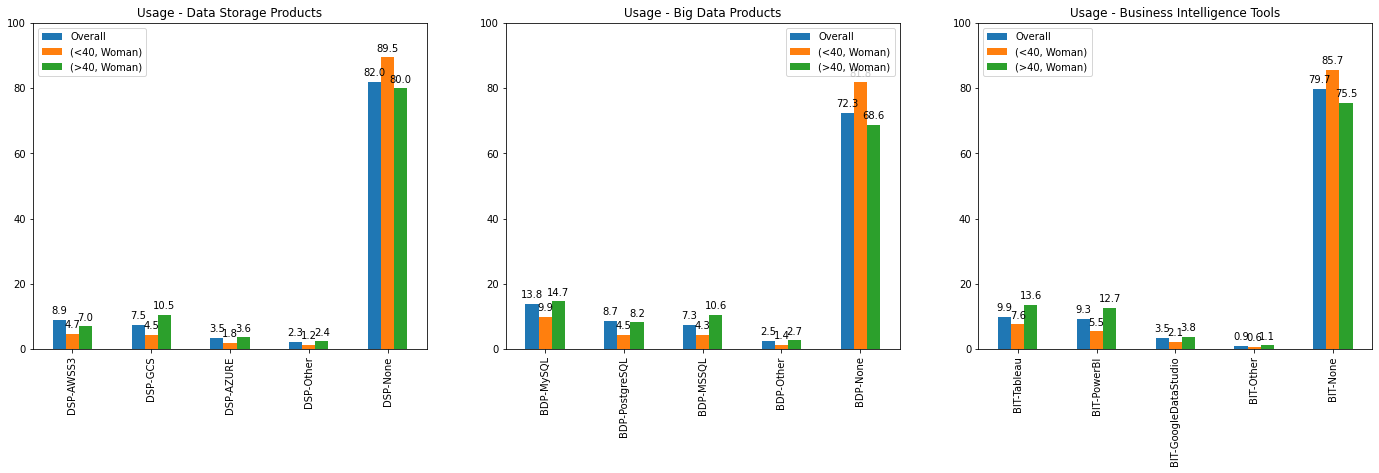

In [4299]:
plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
CAT = "DSP"; Q_PREFIX = "Q30_A"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}7'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}3', CAT+ '-' + 'AWSS3', "Amazon Simple Storage Service (S3)",
            f'{Q_PART_PREFIX}5', CAT+ '-' + 'GCS', "Google Cloud Storage (GCS)",
            f'{Q_PART_PREFIX}1', CAT+ '-' + 'AZURE', "Microsoft Azure Data Lake Storage", ax, "Usage - Data Storage Products") 

ax = plt.subplot(1, 3, 2)
CAT = "BDP"; Q_PREFIX = "Q32_A"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}20'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}1', CAT+ '-' + 'MySQL', "MySQL",
            f'{Q_PART_PREFIX}2', CAT+ '-' + 'PostgreSQL', "PostgreSQL",
            f'{Q_PART_PREFIX}8', CAT+ '-' + 'MSSQL', "Microsoft SQL Server", ax, "Usage - Big Data Products")  

ax = plt.subplot(1, 3, 3)
CAT = "BIT"; Q_PREFIX = "Q34_A"
Q_PART_PREFIX = f'{Q_PREFIX}_Part_'; COL_NONE = f'{Q_PART_PREFIX}16'
COLS, _, COLS_OTHER, _ = getCols(CAT, Q_PREFIX, COL_NONE, )
df[COLS].head()
summarise(df, df_new, CAT, COLS, COLS_OTHER, COL_NONE,
            f'{Q_PART_PREFIX}5', CAT+ '-' + 'Tableau', "Tableau",
            f'{Q_PART_PREFIX}2', CAT+ '-' + 'PowerBI', "Microsoft Power BI",
            f'{Q_PART_PREFIX}3', CAT+ '-' + 'GoogleDataStudio', "Google Data Studio", ax, "Usage - Business Intelligence Tools")  

### Next

In [4300]:
COLS_XXX = ['Age','Gender','AgeGroup','PL-Count','PL-None','IDE-Count','IDE-None','HNB-Count','HNB-None','HW-Count','HW-None']
COLS_XXX_INT = ['PL-Count','PL-None','IDE-Count','IDE-None','HNB-Count','HNB-None','HW-Count','HW-None']
COLS_XXX_COUNT = ['PL-Count','IDE-Count','HNB-Count','HW-Count']
COLS_XXX_NONE = ['PL-None','IDE-None','HNB-None','HW-None']
df_new[COLS_XXX].head()

,Age,Gender,AgeGroup,PL-Count,PL-None,IDE-Count,IDE-None,HNB-Count,HNB-None,HW-Count,HW-None
0,50-54,Man,>40,2,0,1,0,1,0,1,0
1,50-54,Man,>40,4,0,2,0,2,0,0,1
2,22-24,Man,<40,3,0,3,0,1,0,1,0
3,45-49,Man,>40,1,0,2,0,1,0,1,0
4,45-49,Man,>40,3,0,3,0,1,0,0,1


           Overall    <40   >40
PL-Count     65568  10262  1684
PL-None       1351    272   107
IDE-Count    64020   9765  1534
IDE-None      1565    303   125
HNB-Count    30513   4630   714
HNB-None      8337   1373   324
HW-Count     13184   1669   273
HW-None      14625   2691   505


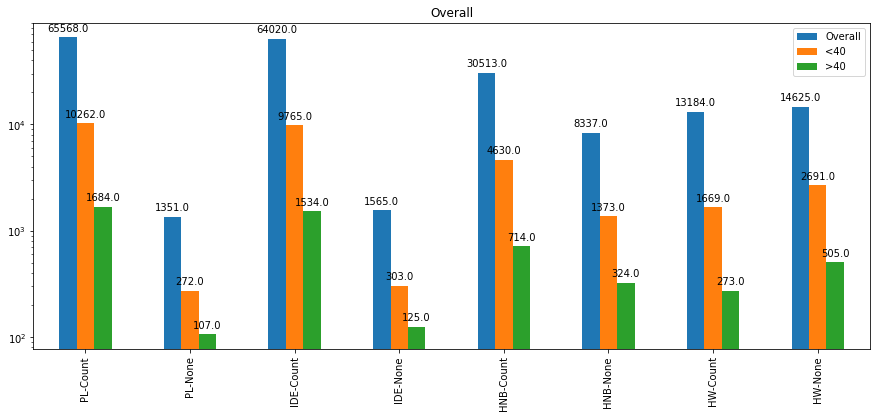

In [4301]:
# TODO: Percentage as well
# Concatenate the overall and the woman < 40 and woman > 40 data 
df_temp = pd.concat([df_new[COLS_XXX_INT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')][COLS_XXX_INT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')][COLS_XXX_INT].sum()], 
                    axis=1, join='inner')
df_temp.rename(columns={0:'Overall',1:'<40',2:'>40'}, inplace=True)
print(df_temp)
ax = df_temp.plot.bar(logy=True, figsize=(15, 6));annotate(ax, "Overall") #ylim=(0,100),

           Overall    <40   >40
PL-Count     65568  10262  1684
IDE-Count    64020   9765  1534
HNB-Count    30513   4630   714
HW-Count     13184   1669   273


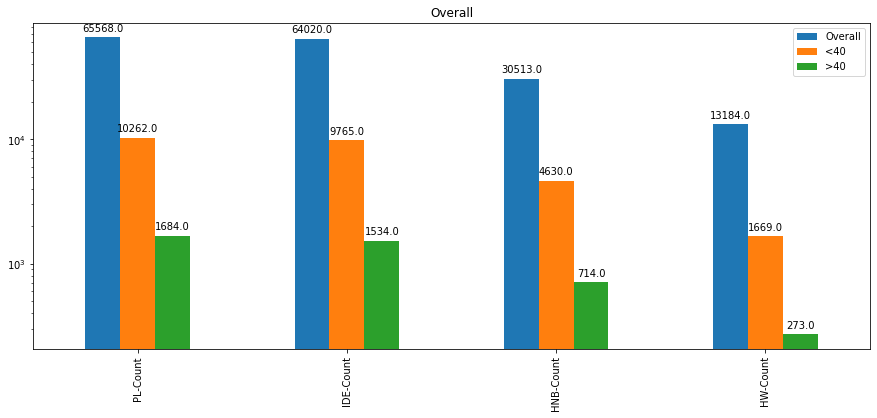

In [4302]:
# Concatenate the overall and the woman < 40 and woman > 40 data 
df_temp = pd.concat([
                    df_new[COLS_XXX_COUNT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')][COLS_XXX_COUNT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')][COLS_XXX_COUNT].sum()], 
                    axis=1, join='inner')
df_temp.rename(columns={0:'Overall',1:'<40',2:'>40'}, inplace=True)
print(df_temp)
ax = df_temp.plot.bar(logy=True, figsize=(15, 6));annotate(ax, "Overall") #ylim=(0,100),

### Using NONE

          Overall  Woman<40  Woman>40
PL-None      5.20      6.56     14.40
IDE-None     6.03      7.31     16.82
HNB-None    32.10     33.11     43.61
HW-None     56.31     64.89     67.97


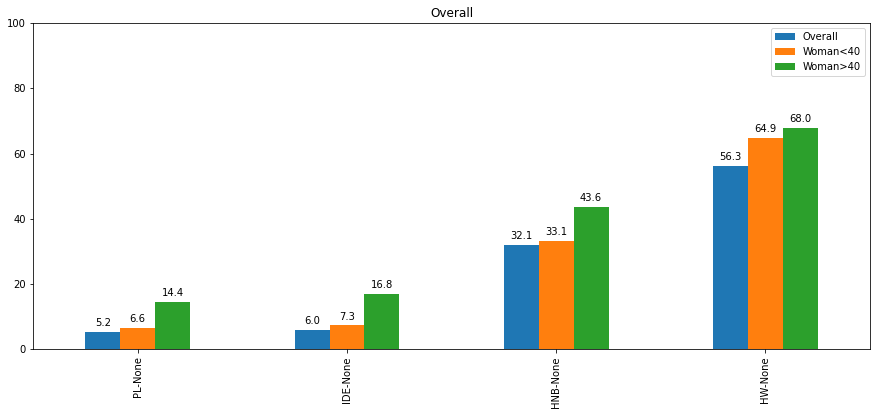

In [4303]:
# Concatenate the overall and the woman < 40 and woman > 40 data 
df_temp = pd.concat([df_new[COLS_XXX_NONE].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')][COLS_XXX_NONE].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')][COLS_XXX_NONE].sum()], 
                    axis=1, join='inner')
df_temp.rename(columns={0:'Overall',1:'Woman<40',2:'Woman>40'}, inplace=True)
df_temp['Overall'] = round((df_temp['Overall']/df.shape[0])*100,2)
df_temp['Woman<40'] = round((df_temp['Woman<40']/df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')].shape[0])*100,2)
df_temp['Woman>40'] = round((df_temp['Woman>40']/df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')].shape[0])*100,2)
print(df_temp)
ax = df_temp.plot.bar(ylim=(0,100),figsize=(15, 6));annotate(ax, "Overall") #ylim=(0,100),

### Median Values

In [4304]:
df_RESULT

,Count-Median,W<40-Median,W>40-Median,Count-Max,W<40-Max,W>40-Max
PL,2.0,2.0,2.0,12.0,12.0,9.0
IDE,2.0,2.0,2.0,12.0,11.0,11.0
HNB,1.0,1.0,1.0,16.0,16.0,15.0
Viz,2.0,2.0,2.0,11.0,10.0,10.0
MLFW,2.0,1.0,1.0,17.0,17.0,16.0
MLA,2.0,1.0,2.0,11.0,10.0,10.0
CV,0.0,0.0,0.0,6.0,6.0,5.0
NLP,0.0,0.0,0.0,5.0,5.0,4.0
AML,0.0,0.0,0.0,7.0,6.0,6.0
HW,0.0,0.0,0.0,5.0,4.0,4.0


<AxesSubplot:>

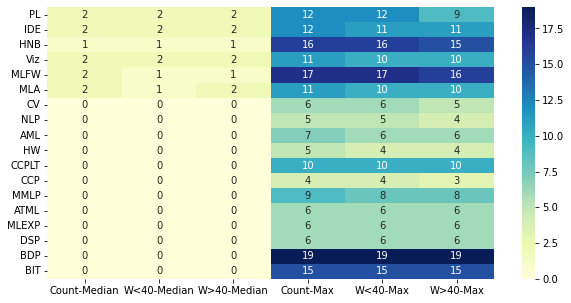

In [4305]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_RESULT, annot=True, fmt="g", cmap="YlGnBu")

The median values for Woman>40 follow a similar trend as the overall and the Woman < 40 categories

## Learn
What is the interest in learning the Data science? 
Media-use

## Summary

Usage indicates Profeciency & what roles
Learn: Interest

Development Toolset/Environment
Programming Languages, IDE, Tools, Frameworks
Data Viz Libraries/Tools,

Machine Learning Concepts, Practices
Algorithms, CV, NLP, AutoML

Managed Platforms & Products 
Cloud Computing Platforms, Cloud Computing Products
Big Data Products, Data Storage Products, BI Tools 
Maanged ML Products, Manage Machine Learning Experiments


| | | | |
|---|---|---|---|
| Programming Language| | | |
| IDE | | | |
| Hosted Notebook | | | |
| Hardware | | | |
| | | | |
| | | | |

In [4306]:
COLS_DS, COLS_DS_TOP3, COLS_DS_OTHER, COLS_DS_NONE = getCols('DS',  'Q40', 'Q40_Part_11', )
df[COLS_DS].head()

COLS_DS       11: Q40_Part_1, Q40_Part_2, Q40_Part_3, Q40_Part_4, Q40_Part_5, Q40_Part_6, Q40_Part_7, Q40_Part_8, Q40_Part_9, Q40_Part_10, Q40_OTHER, 
COLS_DS_TOP3   3: Q40_Part_1, Q40_Part_3, Q40_Part_7, 
COLS_DS_OTHER  8: Q40_Part_2, Q40_Part_4, Q40_Part_5, Q40_Part_6, Q40_Part_8, Q40_Part_9, Q40_Part_10, Q40_OTHER, 
COLS_DS_NONE   1: Q40_Part_11, 


,Q40_Part_1,Q40_Part_2,Q40_Part_3,Q40_Part_4,Q40_Part_5,Q40_Part_6,Q40_Part_7,Q40_Part_8,Q40_Part_9,Q40_Part_10,Q40_OTHER
,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Coursera,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - edX,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Kaggle Learn Courses,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - DataCamp,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Fast.ai,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udacity,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udemy,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - LinkedIn Learning,"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Cloud-certification programs (direct from AWS, Azure, GCP, or similar)",On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - University Courses (resulting in a university degree),On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Other
0,Coursera,edX,Kaggle Learn Courses,DataCamp,NaN,Udacity,Udemy,NaN,NaN,NaN,NaN
1,NaN,NaN,Kaggle Learn Courses,NaN,NaN,NaN,NaN,NaN,"Cloud-certification programs (direct from AWS,...",University Courses (resulting in a university ...,NaN
2,NaN,NaN,NaN,DataCamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coursera,edX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Kaggle Learn Courses,NaN,NaN,NaN,Udemy,NaN,NaN,NaN,NaN


In [4307]:
summarise(df, df_new, 'DS', COLS_DS, COLS_DS_OTHER, 
            'Q40_Part_1', 'DS-Coursera', "Coursera",
            'Q40_Part_3', 'DS-Kaggle', "Kaggle Learn Courses",
            'Q40_Part_7', 'DS-Udemy', "Udemy", 
            'Q40_Part_11')

KeyError: 'DS-Coursera'

Around 73% of woman > 40 are engaged in learning data science topics. This is bit higher than that compared to the complete community and the women < 40 years category.

The top courses they have been taking are by "Coursera", "Kaggle Learn Courses" and "Udemy"

In [ ]:
df_new['DS-Count'].median()